# Analyse Exploratoire

Ce notebook renferme toute l'analyse exploratoire concernant le projet "Segmentez des clients d'un site e-commerce".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px
import time
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta

### Méthodes du projet

In [2]:
def translate_product_category(data_products):
    """ Traduire les catégorie de produit du brésilien au français """
    mapping_names = pd.read_csv(
        "product_category_name_translation.csv", encoding='utf-8', sep=',',
        index_col="product_category_name").to_dict(
    )
    if 'product_category_name' in data_products.columns:
        data_products.replace(
            {"product_category_name": mapping_names['product_category_name_english']},
            inplace=True
        )

In [3]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    """ Affiche le pourcentage de chaque portion si la condition est vérifiée """
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

In [4]:
def show_unique_values(df, col, display_pie=True, silent=False):
    """
    Affiche la liste des valeurs uniques contenues dans une colonne
    Affiche le pie chart de ces données également
    """
    temp_val_count = df[col].value_counts(normalize=True)
    df_val_count = temp_val_count.rename_axis("categ").to_frame("%")
    df_val_count["%"] = round(df_val_count["%"]*100, 2)
    df_val_count["%_cumul"] = df_val_count["%"].cumsum()
    # afficher la majeur partie des catégories
    sub_display = df_val_count.loc[df_val_count["%_cumul"] <= 85, :]
    
    if silent:
        return sub_display
    
    if len(sub_display) < 5:
        display(df_val_count.head())
    else:
        display(sub_display.head(len(sub_display)))
    if display_pie:
        temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
        plt.axis('equal')
        plt.show()
    return sub_display

In [5]:
def show_missing_value_list(df, top=10, precision=3):
    """ Affiche la liste des colonnes avec leur part de données manquantes """
    miss_values = round(df.isnull().mean()*100, precision).sort_values(ascending=False)
    missing_val_df = pd.DataFrame(miss_values, columns = ["%"])
    display(missing_val_df.head(top))

In [6]:
# pour séparer les colonnes par type de donnée
def split_data_num_categ(df, silent=False):
    """ Sépare le df en plusieurs df renfermant les colonnes de même type de données """
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    dict_col = {
        'numeric': [],
        'category': [],
        'boolean': [],
        'datetime': [],
        'deltatime': []
    }
    
    for col in df.columns:
        if df[col].dtype.name in ('float64', 'int64'):
            dict_col['numeric'].append(col)
        elif df[col].dtype.name in ('object', 'category'):
            dict_col['category'].append(col)
        elif df[col].dtype.name == 'bool':
            dict_col['boolean'].append(col)
        elif df[col].dtype.name == 'datetime64[ns]':
            dict_col['datetime'].append(col)
        elif df[col].dtype.name == 'timedelta[ns]':
            dict_col['deltatime'].append(col)
        else:
            print("Type de données non connu :", df[col].dtype.name, "pour la colonne", col)

    if not silent:
        print("Voici la répartition des colonnes par type de données :")
    for key, value in dict_col.items():
        nb_col_by_type = len(value)
        if not silent:
            print(key, ":", nb_col_by_type, "colonnes.")
        if nb_col_by_type > 0:
            result.append(df[value])
    
    return result

In [7]:
def show_corr_col(df, data_num, threshold=0.9, top=10):
    """ Affiche toutes les variables numériques corrélées en fonction du seuil défini """
    list_col_num = data_num.columns
    corr = df[list_col_num].corr().values
    nb_col = len(data_num.columns)
    res = []
    for i in range(nb_col):
        for j in range(i+1, nb_col):
            if abs(corr[i,j]) >= threshold:
                # print(list_col_num[i], ' ', list_col_num[j], ' ', round(corr[i,j], 3))
                res.append([list_col_num[i], list_col_num[j], round(corr[i,j], 3)])
    result = pd.DataFrame(res, columns=['col1', 'col2', 'corr'])
    result = result.sort_values(by="corr", ascending=False)
    display(result.head(top))

In [8]:
def plot_univarie(df, list_col):
    """ Affiche les mesures et les histogrammes de variables numériques """
    for col in list_col:
        print("-"*70)
        print("Colonne :", col)
        # mesures de tendances centrales
        print("moyenne : ", df[col].mean())
        print("médiane : ", df[col].median())
        print("mode : ", df[col].mode())
        print("min : ", df[col].min())
        print("max : ", df[col].max())
        quartiles = [np.percentile(df[col], p) for p in [25, 75]]
        print("quartiles : ", quartiles)
        # mesures de dispersion
        print("variance : ", df[col].var(ddof=0))
        print("écart-type : ", df[col].std(ddof=0))
        print("coefficient de variation : ", df[col].std(ddof=0)/df[col].mean())
        # mesures de forme
        print("skewness : ", df[col].skew())
        print("kurtosis : ", df[col].kurtosis())
        df[col].hist(bins=25)
        plt.xlabel(col)
        # pour tracer les 1er et 3ème quartiles
        min_ylim, max_ylim = plt.ylim()
        # plt.xticks(np.arange(-15, 41, 5))
        plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
        plt.text(quartiles[0], max_ylim*0.95, ' {:.0f}'.format(quartiles[0]))
        plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
        plt.text(quartiles[1], max_ylim*0.85, ' {:.0f}'.format(quartiles[1]))
        plt.show()
        print("-"*70)

In [9]:
def boxplot_univarie(df, list_col, showfliers=True):
    """ Affiche les boxplot de variables numériques """
    for col in list_col:
        print("-"*70)
        print("Colonne :", col)
        df.boxplot(column=col, vert=False, showfliers=showfliers)
        plt.show()
        print("-"*70)

In [10]:
def show_pair_plot(df):
    """ Affiche un pariplot avec toutes les variables numériques """
    temp_data_num, *remain = split_data_num_categ(df, silent=True)
    sns.pairplot(df[temp_data_num.columns])

In [11]:
def remove_dupli_row(df, col_to_compare):
    """ Supprime les lignes dupliquées en fonction des colonnes à comparer """
    nb_line_orig = df.shape[0]
    df = df[col_to_compare].drop_duplicates().reset_index(drop=True)
    diff = nb_line_orig - df.shape[0]
    if diff > 0:
        print(
            "En supprimant les", diff, "lignes dupliquées, le dataset passe de",
            nb_line_orig, "lignes à", df.shape[0], "lignes."
        )
    else:
        print("Aucunes lignes dupliquées pour la liste de colonnes :", col_to_compare)
    return df

In [12]:
def show_corr_anova_col(df, list_col_categ, list_col_num, threshold=0.6):
    """ Affiche les corrélations entre les variables numériques et catégorielles (ANOVA) """
    # X : variable qualitative, ie catégorielle
    # Y : variable quantitative, ie numérique
    def eta_squared(x,y):
        moyenne_y = y.mean()
        classes = []
        for classe in x.unique():
            yi_classe = y[x==classe]
            classes.append({'ni': len(yi_classe),
                            'moyenne_classe': yi_classe.mean()})
        SCT = sum([(yj-moyenne_y)**2 for yj in y])
        SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
        return SCE/SCT
    
    start = time.time()
    print("On dénombre", len(list_col_categ) * len(list_col_num), "combinaisons à calculer.")
    for X in list_col_categ:
        # print("Colonne catégorielle :", X)
        for Y in list_col_num:
            # print("Colonne numérique :", Y)
            temp_eta = eta_squared(df[X],df[Y])
            if temp_eta >= threshold:
                print("-"*70)
                print("Colonne catégorielle :", X)
                print("Colonne numérique :", Y)
                print("Correlation de", round(temp_eta, 3))
    
    end = time.time()
    delta = round(end - start, 0)
    print("Corrélations ANOVA calculées en :", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")

In [13]:
def Plot_world(text):
    """ Affiche l'ensemble des mots en mettant en évidence leur proportion respective """
    comment_words = ' '
    for val in text: 

        # typecaste each val to string 
        val = str(val) 
        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='white', 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

In [14]:
def evaluate_miss_pay_data(df):
    """ Evalue la quantité de données manquantes pour ce cas """
    compare_seq["delta_seq"] = compare_seq[('payment_sequential', 'max')] \
    - compare_seq[('payment_sequential', 'min')] + 1
    compare_seq["delta_install"] = compare_seq[('payment_installments', 'max')] \
    - compare_seq[('payment_installments', 'min')] + 1
    compare_seq["delta_counts"] = compare_seq[('payment_installments', 'count')] \
    - compare_seq[('payment_sequential', 'count')]
    
    compare_seq["miss_count"] = 0
    compare_seq.loc[
        compare_seq[("delta_seq", "")] != compare_seq[('payment_sequential', 'count')],
        "miss_count"] += 1
    compare_seq.loc[
        compare_seq[("delta_install", "")] != compare_seq[('payment_installments', 'count')],
        "miss_count"] += 1
    compare_seq.loc[
        compare_seq[("delta_counts", "")] != 0,
        "miss_count"] += 1
    
    return compare_seq

# I) Elaboration du dataset d'étude

Les données sont dispersées en 8 fichiers. Nous allons d'abord charger chaque fichier pour effectuer un traitement de filtrage préalable si besoin.

## Chargement et traitement des différents fichiers

Il est plus pertinent de faire les traitements de nettoyage et filtrage avant de fusionner les tables. En effet, la fusion va provoquer la création de lignes supplémentaires. Cela va complètement déséquilibrer le master dataset et donc biaiser le traitement des valeurs manquantes.

### Customers

In [15]:
data_customers = pd.read_csv(
    "input/olist_customers_dataset.csv", encoding='utf-8', sep=',',
    dtype=object # le zip code peut commencer par 0
)

In [16]:
data_customers.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

  customer_zip_code_prefix          customer_city customer_state  
0                    14409                 franca             SP  
1                    09790  sao bernardo do campo             SP  
2                    01151              sao paulo             SP  
3                    08775        mogi das cruzes             SP  
4                    13056               campinas             SP

Regardons les variables de ce dataset : 
 - `customer_id` : identifiant servant de foreign key pour la table **orders**
 - `customer_unique_id` : identifiant unique du client. Un même identifiant unique peut avoir plusieurs `customer_id`
 - `customer_zip_code_prefix` : identifiant servant de foreign key pour la table **geolocation**
 - `customer_city` : ville où vit le client
 - `customer_state` : état où vit le client

In [17]:
print("Ce dataset présente", data_customers.shape[0], "lignes pour", data_customers.shape[1], "colonnes.")

Ce dataset présente 99441 lignes pour 5 colonnes.


### Products

In [18]:
data_products = pd.read_csv(
    "input/olist_products_dataset.csv", encoding='utf-8', sep=','
)

In [19]:
data_products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

Regardons les variables de ce dataset : 
 - `product_id` : identifiant servant de aussi de foreign key pour la table **order_items**
 - `product_category_name` : catégorie du produit
 - `product_name_lenght` : longueur du nom sur la fiche produit
 - `product_description_lenght` : longueur de la description sur la fiche produit
 - `product_photos_qty` : nombre de photo sur la fiche produit
 - `product_weight_g` : poids du produit
 - `product_length_cm` : longueur du produit
 - `product_height_cm` : hauteur du produit
 - `product_width_cm` : largeur du produit

La variable `product_category_name` peut être traduite par l'intérmédiaire du fichier fournit en annexe.

In [20]:
translate_product_category(data_products)

Regardons les corrélations possibles entre les différentes variables numériques.

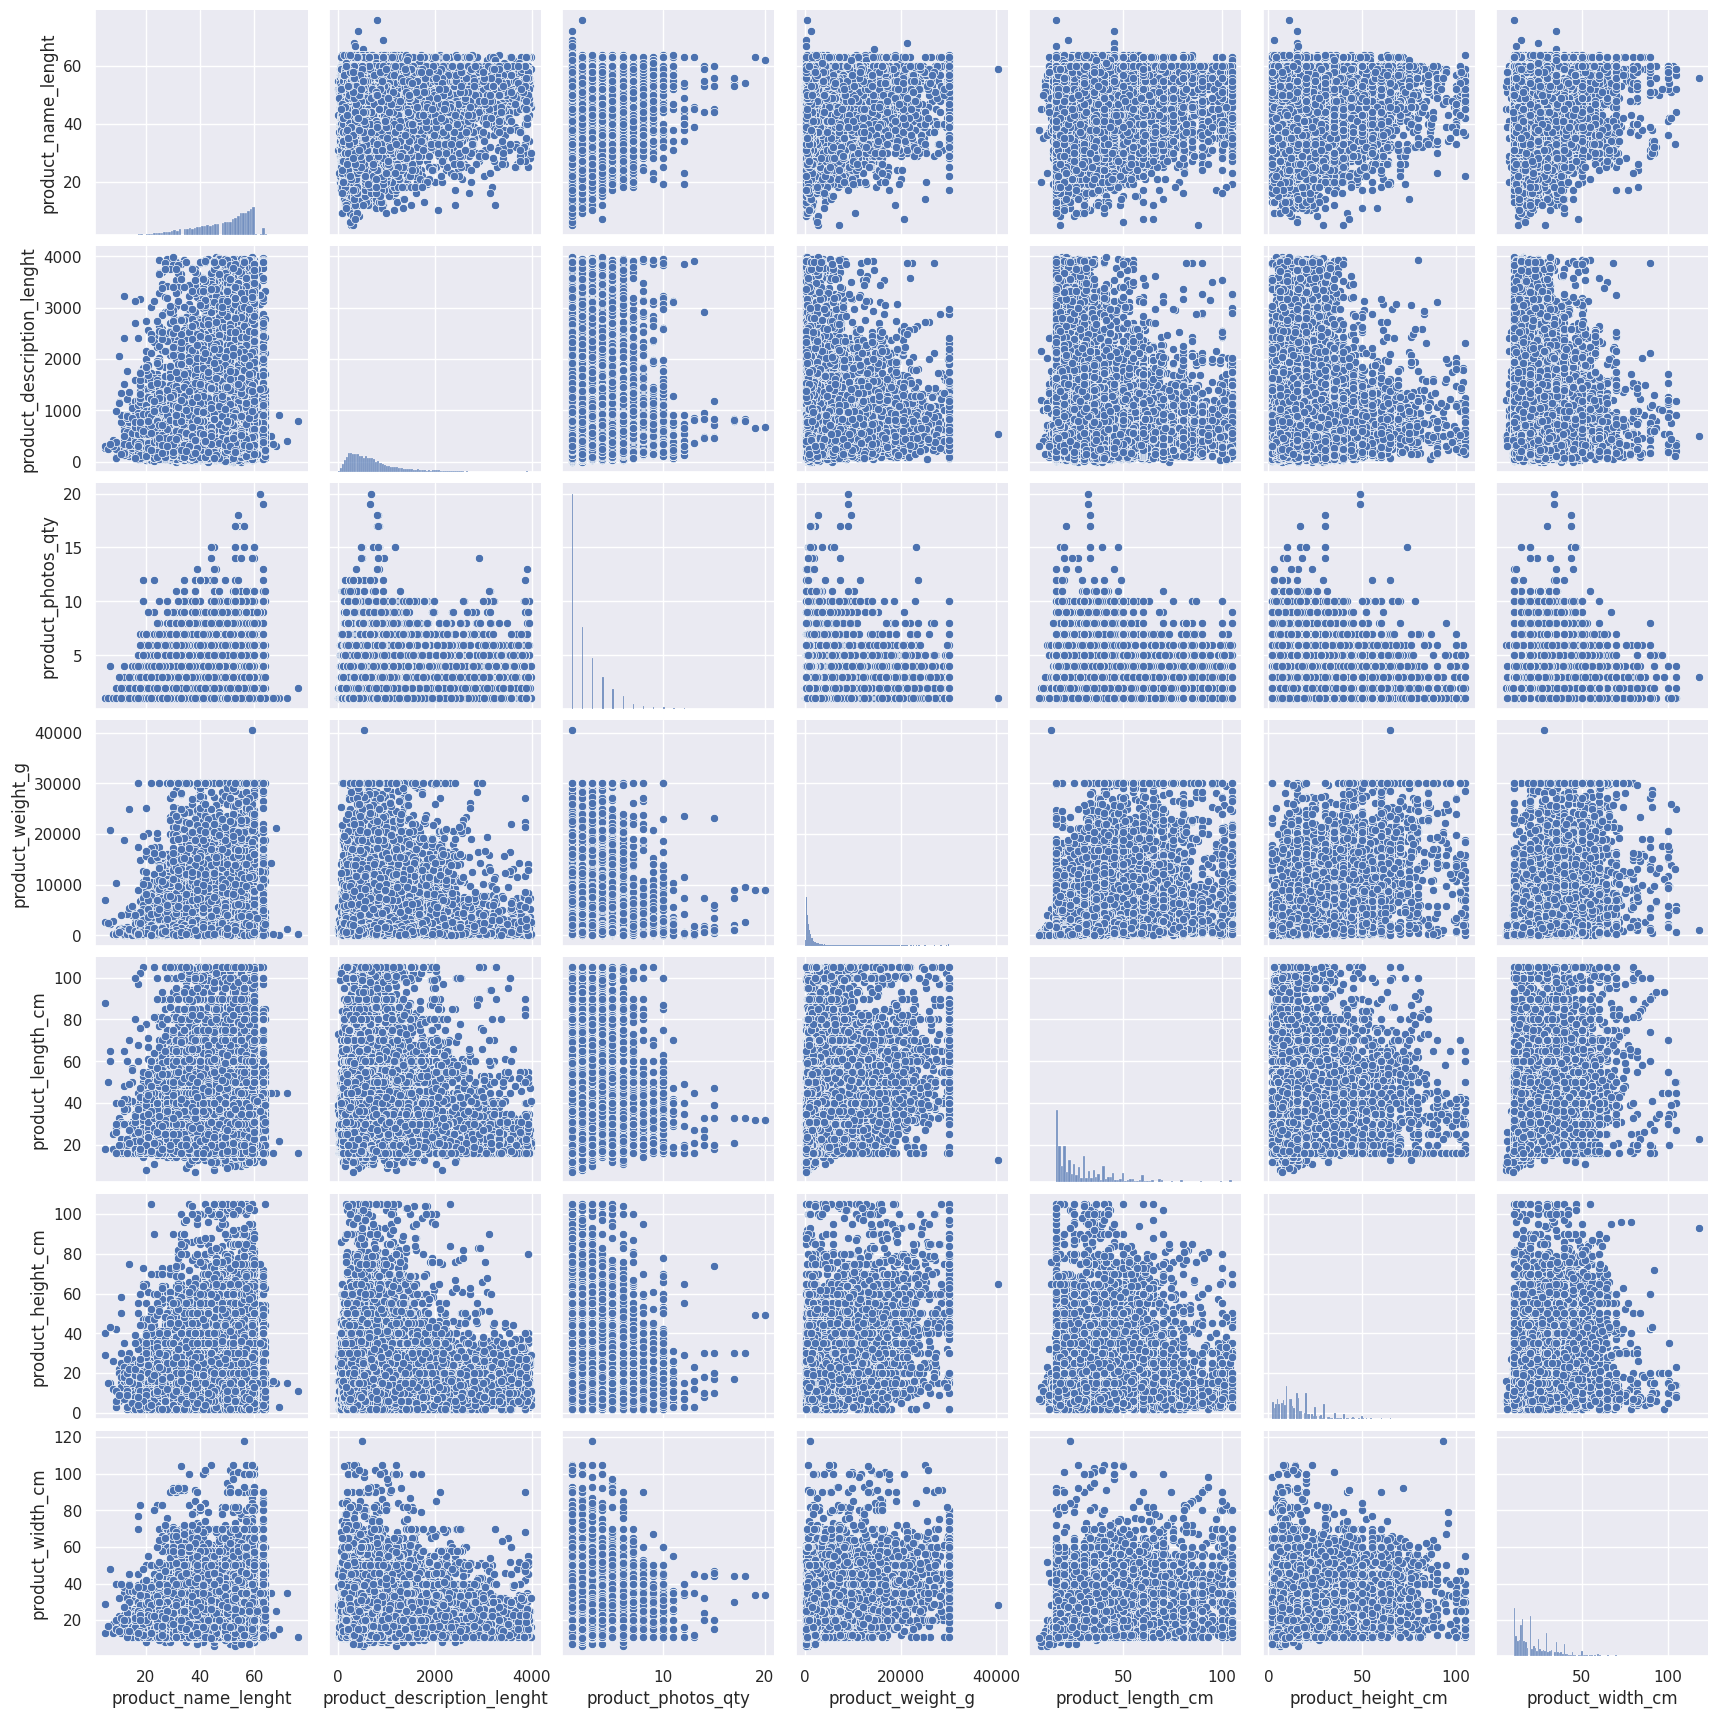

In [21]:
show_pair_plot(data_products)

On n'observe rien de marquant. Regardons maintenant les valeurs manquantes.

In [22]:
show_missing_value_list(data_products)

%
product_category_name       1.851
product_name_lenght         1.851
product_description_lenght  1.851
product_photos_qty          1.851
product_weight_g            0.006
product_length_cm           0.006
product_height_cm           0.006
product_width_cm            0.006
product_id                  0.000

On remarque que certaines variables ont la même valeur de données manquantes : 
 - la désignation de la fiche produit
 - les dimensions

Même si certaines données sont manquantes, ils peuvent avoir été achetés. ils ont donc potentiellement un prix et une fréquence d'achat. Nous allons donc les garder mais les traiter de la manière suivante : 
 - `product_category_name` : on renseigne la valeur "not_defined" car aucun moyen de savoir ce qu'est le produit
 - `product_name_lenght`, `product_description_lenght` et `product_photos_qty` : on renseigne la valeur minimale car nous faisons l'approximation qu'on ne peut créer une fiche sans aucune de ces données
 - `product_weight_g`, `product_length_cm`, `product_height_cm` et `product_width_cm` : on renseigne la valeur médiane

In [23]:
# traitement avec not_defined
data_products["product_category_name"].fillna("not_defined", inplace=True)
# traitement par le minimum
for col_fiche in ["product_name_lenght", "product_description_lenght", "product_photos_qty"]:
    data_products[col_fiche].fillna(data_products[col_fiche].min(), inplace=True)
# traitement par la médiane
for col_dim in ["product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]:
    data_products[col_dim].fillna(data_products[col_dim].median(), inplace=True)

Regardons maintenant les outliers.

In [24]:
data_products.describe()

product_name_lenght  product_description_lenght  product_photos_qty  \
count         32951.000000                32951.000000        32951.000000   
mean             47.672089                  757.287154            2.166975   
std              11.720832                  637.657356            1.728063   
min               5.000000                    4.000000            1.000000   
25%              41.000000                  326.000000            1.000000   
50%              51.000000                  584.000000            1.000000   
75%              57.000000                  961.000000            3.000000   
max              76.000000                 3992.000000           20.000000   

       product_weight_g  product_length_cm  product_height_cm  \
count      32951.000000       32951.000000       32951.000000   
mean        2276.376802          30.814725          16.937422   
std         4281.926387          16.914005          13.637175   
min            0.000000           7.000000           2.000000   
25%          300.000000          18.000000           8.000000   
50%          700.000000          25.000000          13.000000   
75%         1900.000000          38.000000          21.000000   
max        40425.000000         105.000000         105.000000   

       product_width_cm  
count      32951.000000  
mean          23.196534  
std           12.078707  
min            6.000000  
25%           15.000000  
50%           20.000000  
75%           30.000000  
max          118.000000

La seule valeur aberrante observée est le poids minimum à 0g.

In [25]:
poids_a_zero = data_products.loc[data_products["product_weight_g"]==0]
print("Poids à zéro :", len(poids_a_zero), ", soit", str(round(len(poids_a_zero)/len(data_products)*100, 2)), "% du total.")

Poids à zéro : 4 , soit 0.01 % du total.


In [26]:
poids_a_zero.head()

product_id product_category_name  \
9769   81781c0fed9fe1ad6e8c81fca1e1cb08        bed_bath_table   
13683  8038040ee2a71048d4bdbbdc985b69ab        bed_bath_table   
14997  36ba42dd187055e1fbe943b2d11430ca        bed_bath_table   
32079  e673e90efa65a5409ff4196c038bb5af        bed_bath_table   

       product_name_lenght  product_description_lenght  product_photos_qty  \
9769                  51.0                       529.0                 1.0   
13683                 48.0                       528.0                 1.0   
14997                 53.0                       528.0                 1.0   
32079                 53.0                       528.0                 1.0   

       product_weight_g  product_length_cm  product_height_cm  \
9769                0.0               30.0               25.0   
13683               0.0               30.0               25.0   
14997               0.0               30.0               25.0   
32079               0.0               30.0               25.0   

       product_width_cm  
9769               30.0  
13683              30.0  
14997              30.0  
32079              30.0

On voit que ces produits sont de la même catégorie et ont les mêmes dimensions. On va donc récupérer la valeur médiane des produits ayant ces critères.

In [27]:
filtered_poids_zero = data_products.loc[
    (data_products["product_category_name"]=="bed_bath_table") &
    (data_products["product_length_cm"]==30) &
    (data_products["product_height_cm"]==25) &
    (data_products["product_width_cm"]==30) &
    (data_products["product_weight_g"]!=0), :]
data_products.loc[data_products["product_weight_g"]==0,"product_weight_g"] = filtered_poids_zero["product_weight_g"].median()

In [28]:
print("Ce dataset présente", data_products.shape[0], "lignes pour", data_products.shape[1], "colonnes.")

Ce dataset présente 32951 lignes pour 9 colonnes.


### Sellers

In [29]:
data_sellers = pd.read_csv(
    "input/olist_sellers_dataset.csv", encoding='utf-8', sep=',',
    dtype=object # le zip code peut commencer par 0
)

In [30]:
data_sellers.head()

seller_id seller_zip_code_prefix        seller_city  \
0  3442f8959a84dea7ee197c632cb2df15                  13023           campinas   
1  d1b65fc7debc3361ea86b5f14c68d2e2                  13844         mogi guacu   
2  ce3ad9de960102d0677a81f5d0bb7b2d                  20031     rio de janeiro   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                  04195          sao paulo   
4  51a04a8a6bdcb23deccc82b0b80742cf                  12914  braganca paulista   

  seller_state  
0           SP  
1           SP  
2           RJ  
3           SP  
4           SP

Regardons les variables de ce dataset : 
 - `seller_id` : identifiant servant de aussi de foreign key pour la table **order_items**
 - `seller_zip_code_prefix` : identifiant servant de foreign key pour la table **geolocation**
 - `seller_city` : ville où est basé le vendeur
 - `seller_state` : état dans lequel est basé le vendeur

In [31]:
print("Ce dataset présente", data_sellers.shape[0], "lignes pour", data_sellers.shape[1], "colonnes.")

Ce dataset présente 3095 lignes pour 4 colonnes.


### Geolocation

In [32]:
data_geolocation = pd.read_csv(
    "input/olist_geolocation_dataset.csv", encoding='utf-8', sep=',',
    dtype={'geolocation_zip_code_prefix': 'object'} # le zip code peut commencer par 0
)

In [33]:
data_geolocation.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                       01037       -23.545621       -46.639292   
1                       01046       -23.546081       -46.644820   
2                       01046       -23.546129       -46.642951   
3                       01041       -23.544392       -46.639499   
4                       01035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

Regardons les variables de ce dataset : 
 - `geolocation_zip_code_prefix` : identifiant servant de foreign key pour les tables **customers** et **sellers**
 - `geolocation_lat` : latitude
 - `geolocation_lng` : longitude
 - `geolocation_city` : ville
 - `geolocation_state` : état (du pays)

In [34]:
data_geolocation = remove_dupli_row(data_geolocation, data_geolocation.columns)

En supprimant les 261831 lignes dupliquées, le dataset passe de 1000163 lignes à 738332 lignes.


In [35]:
print("Ce dataset présente", data_geolocation.shape[0], "lignes pour", data_geolocation.shape[1], "colonnes.")

Ce dataset présente 738332 lignes pour 5 colonnes.


### Payments

In [36]:
data_payments = pd.read_csv(
    "input/olist_order_payments_dataset.csv", encoding='utf-8', sep=','
)

In [37]:
data_payments.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

Regardons les variables de ce dataset : 
 - `order_id` : identifiant servant de aussi de foreign key pour la table **orders**
 - `payment_sequential` : séquence d'un paiement si en plusieurs fois
 - `payment_type` : méthode de paiement
 - `payment_installments` : nombre d'échance pour le paiement de la commande
 - `payment_value` : montant de la transaction en real brésilien

Pour une meilleure compréhension, nous allons convertir les real brésilien en euros, par la conversion de 1R$ = 0.18€.

In [38]:
data_payments["payment_value"] = data_payments["payment_value"] * 0.18

NB : Je voulais faire une aggrégation des données pour avoir le montant total et le nombre d'échéance payées. Mais le fait que la commande peut avoir plusieurs méthodes de paiement m'en empêche.

In [39]:
data_payments.describe()

payment_sequential  payment_installments  payment_value
count       103886.000000         103886.000000  103886.000000
mean             1.092679              2.853349      27.738068
std              0.706584              2.687051      39.148931
min              1.000000              0.000000       0.000000
25%              1.000000              1.000000      10.222200
50%              1.000000              1.000000      18.000000
75%              1.000000              4.000000      30.930750
max             29.000000             24.000000    2459.534400

On voit des valeurs aberrantes pour le montant de la transaction et le nombre d'échéance avec des valeurs à zéro.

In [40]:
mont_trans_a_zero = data_payments.loc[data_payments["payment_value"]==0, :]
print("Montant de la transaction à zéro :", len(mont_trans_a_zero), ", soit", str(round(len(mont_trans_a_zero)/len(data_payments)*100, 2)), "% du total.")
mont_trans_a_zero.head(len(mont_trans_a_zero))

Montant de la transaction à zéro : 9 , soit 0.01 % du total.


order_id  payment_sequential payment_type  \
19922   8bcbe01d44d147f901cd3192671144db                   4      voucher   
36822   fa65dad1b0e818e3ccc5cb0e39231352                  14      voucher   
43744   6ccb433e00daae1283ccc956189c82ae                   4      voucher   
51280   4637ca194b6387e2d538dc89b124b0ee                   1  not_defined   
57411   00b1cb0320190ca0daa2c88b35206009                   1  not_defined   
62674   45ed6e85398a87c253db47c2d9f48216                   3      voucher   
77885   fa65dad1b0e818e3ccc5cb0e39231352                  13      voucher   
94427   c8c528189310eaa44a745b8d9d26908b                   1  not_defined   
100766  b23878b3e8eb4d25a158f57d96331b18                   4      voucher   

        payment_installments  payment_value  
19922                      1            0.0  
36822                      1            0.0  
43744                      1            0.0  
51280                      1            0.0  
57411                      1            0.0  
62674                      1            0.0  
77885                      1            0.0  
94427                      1            0.0  
100766                     1            0.0

Le type de paiement de ces montants sont voucher (bon alimentaire) et non défini. Regardons les séparément.

In [41]:
pay_voucher = data_payments.loc[data_payments["payment_type"]=="voucher", :]
pay_voucher.head()

order_id  payment_sequential payment_type  \
25   5cfd514482e22bc992e7693f0e3e8df7                   2      voucher   
68   947e9c6bfd83a06953c420ef92d3da6e                   1      voucher   
70   e3e9e3295f4e1512167c232a0aaae8a5                   1      voucher   
75   3689194c14ad4e2e7361ebd1df0e77b0                   2      voucher   
102  21b8b46679ea6482cbf911d960490048                   2      voucher   

     payment_installments  payment_value  
25                      1         8.1306  
68                      1        12.5028  
70                      1         9.1440  
75                      1        10.3554  
102                     1         7.7616

Les bons alimentaires ont des montants. nous allons renseigner la valeur médiane pour celle à 0.

In [42]:
mask_vouch_val = (data_payments["payment_type"]=="voucher") & (data_payments["payment_value"]!=0)
mask_vouch_zero = (data_payments["payment_type"]=="voucher") & (data_payments["payment_value"]==0)
data_payments.loc[mask_vouch_zero, "payment_value"] = data_payments.loc[mask_vouch_val, "payment_value"].median()

In [43]:
pay_not_defined = data_payments.loc[(data_payments["payment_type"]=="not_defined") & (data_payments["payment_value"]==0), :]
pay_not_defined.head()

order_id  payment_sequential payment_type  \
51280  4637ca194b6387e2d538dc89b124b0ee                   1  not_defined   
57411  00b1cb0320190ca0daa2c88b35206009                   1  not_defined   
94427  c8c528189310eaa44a745b8d9d26908b                   1  not_defined   

       payment_installments  payment_value  
51280                     1            0.0  
57411                     1            0.0  
94427                     1            0.0

Les 3 seules lignes de paiement ayant le type non défini ont des montants à zéro. Nous allons supprimer ces lignes.

In [44]:
data_payments = data_payments.loc[set(data_payments.index) - set(pay_not_defined.index), :].reset_index(drop=True)

Regardons maintenant le nombre d'échéances renseigné à 0.

In [45]:
pay_install_a_zero = data_payments.loc[data_payments["payment_installments"]==0, :]
pay_install_a_zero.head()

order_id  payment_sequential payment_type  \
46982  744bade1fcf9ff3f31d860ace076d422                   2  credit_card   
79012  1a57108394169c0b47d8f876acc9ba2d                   2  credit_card   

       payment_installments  payment_value  
46982                     0        10.5642  
79012                     0        23.3892

Il y a 2 commandes ayant cette particularité. Regardons les autres lignes de ces commandes.

In [46]:
temp_sub_pay = data_payments.loc[
    (data_payments["order_id"]=='744bade1fcf9ff3f31d860ace076d422') | 
    (data_payments["order_id"]=='1a57108394169c0b47d8f876acc9ba2d'), :]
temp_sub_pay.head()

order_id  payment_sequential payment_type  \
46982  744bade1fcf9ff3f31d860ace076d422                   2  credit_card   
79012  1a57108394169c0b47d8f876acc9ba2d                   2  credit_card   

       payment_installments  payment_value  
46982                     0        10.5642  
79012                     0        23.3892

Etant donné la nature de la colonne, la valeur est de minimum 2 puisqu'il y a cette valeur dans le nombre de séquence. Nous choisissons de renseigner 2.

In [47]:
data_payments.loc[temp_sub_pay.index, "payment_installments"] = 2

Nous allons observer où en sont les paiements dans leurs échéances.

In [48]:
agg_pay = {
    'payment_sequential': ['min', 'max', 'count'],
    'payment_installments': ['min', 'max', 'count'],
}

In [49]:
compare_seq = data_payments.groupby(['order_id']).agg(agg_pay)
compare_seq.head()

payment_sequential            \
                                                min max count   
order_id                                                        
00010242fe8c5a6d1ba2dd792cb16214                  1   1     1   
00018f77f2f0320c557190d7a144bdd3                  1   1     1   
000229ec398224ef6ca0657da4fc703e                  1   1     1   
00024acbcdf0a6daa1e931b038114c75                  1   1     1   
00042b26cf59d7ce69dfabb4e55b4fd9                  1   1     1   

                                 payment_installments            
                                                  min max count  
order_id                                                         
00010242fe8c5a6d1ba2dd792cb16214                    2   2     1  
00018f77f2f0320c557190d7a144bdd3                    3   3     1  
000229ec398224ef6ca0657da4fc703e                    5   5     1  
00024acbcdf0a6daa1e931b038114c75                    2   2     1  
00042b26cf59d7ce69dfabb4e55b4fd9                    3   3     1

On voit tout de suite que l'on a des commandes qui en sont à leur premier versement alors qu'il est prévu plus. Ce qui implique que nous n'avons pas toutes les données disponible pour cette table. Il est possible qu'elle ne nous soit pas très utile pour notre étude. Nous allons néanmoins quantifier à quel point cette table manque de données.

In [50]:
compare_seq = evaluate_miss_pay_data(compare_seq)

In [51]:
nb_orders = data_payments["order_id"].nunique()
nb_miss_pay = len(compare_seq.loc[compare_seq["miss_count"] > 0, :])
print("Il manque des données pour", nb_miss_pay, "commandes, soit", str(round(nb_miss_pay/nb_orders*100, 2)), "% des commandes.")

Il manque des données pour 2691 commandes, soit 2.71 % des commandes.


In [52]:
print("Ce dataset présente", data_payments.shape[0], "lignes pour", data_payments.shape[1], "colonnes.")

Ce dataset présente 103883 lignes pour 5 colonnes.


### Reviews

In [53]:
review_date_col = [
    "review_creation_date",
    "review_answer_timestamp"
]
data_reviews = pd.read_csv(
    "input/olist_order_reviews_dataset.csv", encoding='utf-8', sep=',',
    parse_dates=review_date_col
)

In [54]:
data_reviews.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN           2018-01-18   
1                                                NaN           2018-03-10   
2                                                NaN           2018-02-17   
3              Recebi bem antes do prazo estipulado.           2017-04-21   
4  Parabéns lojas lannister adorei comprar pela I...           2018-03-01   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

Regardons les variables de ce dataset : 
 - `review_id` : identifiant unique de la review
 - `order_id` : identifiant servant de aussi de foreign key pour la table **orders**
 - `review_score` : note de la review allant de 1 à 5
 - `review_comment_title` : titre du commentaire de la review
 - `review_comment_message` : corps du commentaire de la review
 - `review_creation_date` : date à laquelle la review a été publiée
 - `review_answer_timestamp` : date à laquelle la review a eu une réponse

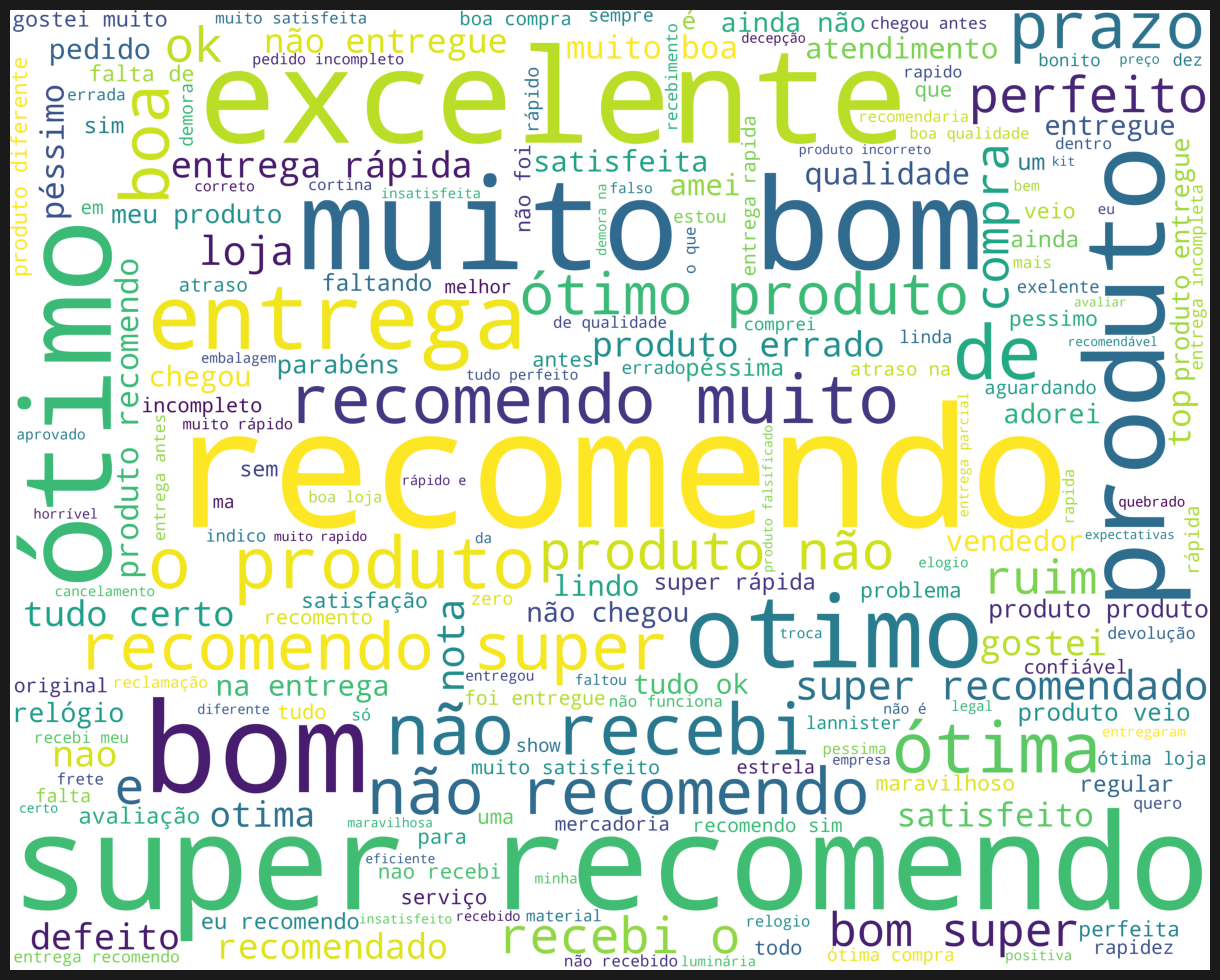

In [55]:
from wordcloud import WordCloud
sub_data = data_reviews.loc[data_reviews["review_comment_title"].notnull(), :]
text = sub_data["review_comment_title"].values
Plot_world(text)

On remarque que certains mots sont plus récurrents dans les titres des commentaires des reviews : 
 - otimo : excellent
 - muito bom : très bon
 - excelente : génial
 - super recomendo : je recommande vivement

In [56]:
show_missing_value_list(data_reviews, top=5, precision=1)

%
review_comment_title    88.3
review_comment_message  58.7
review_id                0.0
order_id                 0.0
review_score             0.0

On peut voir que les notes sont certes toutes renseignée, mais les commentaires ne sont pas forcément remplis. Etant donné le peu de données dans les colonnes `review_comment_title` et `review_comment_message`, nous choisissons de les supprimer.

In [57]:
data_reviews.drop(['review_comment_title', 'review_comment_message'], axis=1, inplace=True)

In [58]:
print("Ce dataset présente", data_reviews.shape[0], "lignes pour", data_reviews.shape[1], "colonnes.")

Ce dataset présente 99224 lignes pour 5 colonnes.


### Items

In [59]:
data_items = pd.read_csv(
    "input/olist_order_items_dataset.csv", encoding='utf-8', sep=',',
    parse_dates=["shipping_limit_date"]
)

In [60]:
data_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value  
0 2017-09-19 09:45:35   58.90          13.29  
1 2017-05-03 11:05:13  239.90          19.93  
2 2018-01-18 14:48:30  199.00          17.87  
3 2018-08-15 10:10:18   12.99          12.79  
4 2017-02-13 13:57:51  199.90          18.14

Regardons les variables de ce dataset : 
 - `order_id` : identifiant unique de la commande
 - `order_item_id` : quantité d'achat du produit
 - `product_id` : identifiant servant de aussi de foreign key pour la table **products**
 - `seller_id` : identifiant servant de aussi de foreign key pour la table **sellers**
 - `shipping_limit_date` : date limite pour le vendeur pour confier le produit au service logistique
 - `price` : prix du produit au moment de la commande
 - `freight_value` : frais de port associés au produit (et non à la commande entière) au moment de la commande

De la même manière que précédemment, et pour une meilleure compréhension, nous allons convertir les real brésilien en euros, par la conversion de 1R$ = 0.18€.

In [61]:
data_items["price"] = data_items["price"] * 0.18
data_items["freight_value"] = data_items["freight_value"] * 0.18

Dans order_items, les produits sont présents plusieurs fois. Pour chaque produits, on a une ligne par quantité d'achat. Chaque ligne nous montre son prix et ses frais de port au moment de l'achat. La variable `order_item_id` renseigne sur la quantité achetée. S'il y a 3 items dans le même panier, il y aura 3 lignes avec les valeurs 1, 2 et 3. Il y aura cependant la même valeurs pour le prix et les frais de port.    
On va d'abord ordonner les lignes par ordre décroissant de la variable `order_item_id`. Puis on va garder la première des lignes dupliquées selon les critères des autres colonnes.

In [62]:
multiple_items_order = data_items.loc[data_items["order_item_id"] > 2, :].sort_values('product_id')
multiple_items_order.head()

order_id  order_item_id  \
60263  895764a4b54b7193c02aa784fabbcaeb              5   
60262  895764a4b54b7193c02aa784fabbcaeb              4   
60261  895764a4b54b7193c02aa784fabbcaeb              3   
61728  8cd68144cdb62dc0d60848cf8616d2a4              4   
61729  8cd68144cdb62dc0d60848cf8616d2a4              5   

                             product_id                         seller_id  \
60263  00250175f79f584c14ab5cecd80553cd  b499c00f28f4b7069ff6550af8c1348a   
60262  00250175f79f584c14ab5cecd80553cd  b499c00f28f4b7069ff6550af8c1348a   
60261  00250175f79f584c14ab5cecd80553cd  b499c00f28f4b7069ff6550af8c1348a   
61728  002af88741ba70c7b5cf4e4a0ad7ef85  3a734b715d333a2588a3d54a0c9b8746   
61729  002af88741ba70c7b5cf4e4a0ad7ef85  3a734b715d333a2588a3d54a0c9b8746   

      shipping_limit_date    price  freight_value  
60263 2018-02-22 07:07:08  14.3982         1.6416  
60262 2018-02-22 07:07:08  14.3982         1.6416  
60261 2018-02-22 07:07:08  14.3982         1.6416  
61728 2017-08-10 02:55:16   7.0200         2.8998  
61729 2017-08-10 02:55:16   7.0200         2.8998

Nous avons le très bon exemple du produit '00250175f79f584c14ab5cecd80553cd'.

In [63]:
specific_product = data_items.loc[
    data_items["product_id"] == '00250175f79f584c14ab5cecd80553cd', :].sort_values(
    by=["order_id", "order_item_id"])
specific_product[["order_id", "order_item_id", "product_id", "price", "freight_value"]].head(8)

order_id  order_item_id  \
24170  3713fe13d5a4c736c62e235af932a494              1   
24820  38886f218185dea64ae0c39a629d89de              1   
45475  674e1f5ca0441058cc7fa110cb4f49eb              1   
60259  895764a4b54b7193c02aa784fabbcaeb              1   
60260  895764a4b54b7193c02aa784fabbcaeb              2   
60261  895764a4b54b7193c02aa784fabbcaeb              3   
60262  895764a4b54b7193c02aa784fabbcaeb              4   
60263  895764a4b54b7193c02aa784fabbcaeb              5   

                             product_id    price  freight_value  
24170  00250175f79f584c14ab5cecd80553cd  14.3982         2.1690  
24820  00250175f79f584c14ab5cecd80553cd   9.8982         1.6362  
45475  00250175f79f584c14ab5cecd80553cd   9.8982         1.9782  
60259  00250175f79f584c14ab5cecd80553cd  14.3982         1.6416  
60260  00250175f79f584c14ab5cecd80553cd  14.3982         1.6416  
60261  00250175f79f584c14ab5cecd80553cd  14.3982         1.6416  
60262  00250175f79f584c14ab5cecd80553cd  14.3982         1.6416  
60263  00250175f79f584c14ab5cecd80553cd  14.3982         1.6416

In [64]:
nb_lines_orig_oi = data_items.shape[0]
data_items = data_items.sort_values(
    'order_item_id', ascending=False).drop_duplicates(
    ["order_id", "product_id", "seller_id", "price", "freight_value"])
diff = nb_lines_orig_oi - data_items.shape[0]
print("En supprimant les", diff, "lignes dupliquées, le dataset passe de", nb_lines_orig_oi, "lignes à", data_items.shape[0], "lignes.")

En supprimant les 10225 lignes dupliquées, le dataset passe de 112650 lignes à 102425 lignes.


In [65]:
print("On a supprimé", round(diff/nb_lines_orig_oi*100, 2), "% des données.")

On a supprimé 9.08 % des données.


In [66]:
data_items.describe()

order_item_id          price  freight_value
count  102425.000000  102425.000000  102425.000000
mean        1.150539      22.395961       3.620007
std         0.563005      34.006695       2.859246
min         1.000000       0.153000       0.000000
25%         1.000000       7.200000       2.365200
50%         1.000000      14.184000       2.937600
75%         1.000000      25.020000       3.819600
max        21.000000    1212.300000      73.742400

Nous voyons de possibles outliers au niveau du prix et des frais de port. On a des valeurs maximales à, respectivement, 1212.30 et 73.74. Cependant, nous ne savons pas quel genre de produit nous avons. Il est possible que ce soit les vrai prix. Pour les frais de port, en fonction du colis, on peut très bien arriver à ce genre de valeur.

In [67]:
print("Ce dataset présente", data_items.shape[0], "lignes pour", data_items.shape[1], "colonnes.")

Ce dataset présente 102425 lignes pour 7 colonnes.


### Orders

In [68]:
order_date_col = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date']
data_orders = pd.read_csv(
    "input/olist_orders_dataset.csv", encoding='utf-8', sep=',',
    parse_dates=order_date_col)

In [69]:
data_orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04  
3                    2017-12-15  
4                    2018-02-26

Regardons les variables de ce dataset : 
 - `order_id` : identifiant servant de aussi de foreign key pour la table **orders**
 - `customer_id` : identifiant servant de aussi de foreign key pour la table **customers**
 - `order_status` : étape dans laquelle est la commande
 - `order_purchase_timestamp` : date à laquelle la commande a été faite par le client
 - `order_approved_at` : date à laquelle le paiement a été approuvé
 - `order_delivered_carrier_date` : date à laquelle le colis a été confié au service de logistique
 - `order_delivered_customer_date` : date à laquelle le colis a été livré au client
 - `order_estimated_delivery_date` : date estimée de livraison au moment de la commande

Tout d'abord, nous souhaitons des données d'articles arrivées à destination. Cela nous permettra d'avoir la vie complète d'un article de sa commande à la livraison, et éventuellement à la note de review. Nous allons donc garder uniquement les données ayant un status livré.

In [70]:
orders_uncomplete = data_orders.loc[data_orders["order_status"] != "delivered", :]
print("Les commandes non livrées représentent", round(len(orders_uncomplete)/len(data_orders)*100, 2), "%")
# data_orders = data_orders.loc[data_orders["order_status"] == "delivered", :]
# # puis on supprime la colonne, n'ayant plus d'utlité
# data_orders.drop(columns="order_status", axis=1, inplace=True)

Les commandes non livrées représentent 2.98 %


In [71]:
show_missing_value_list(data_orders)

%
order_delivered_customer_date  2.982
order_delivered_carrier_date   1.793
order_approved_at              0.161
order_id                       0.000
customer_id                    0.000
order_status                   0.000
order_purchase_timestamp       0.000
order_estimated_delivery_date  0.000

Regardons de plus près les 3 dates ayant des valeurs manquantes en commençant par la date de livraison au client.

In [72]:
sub_data_delivered_date = data_orders.loc[data_orders["order_delivered_customer_date"].isnull(), :]
sub_data_delivered_date.head(len(sub_data_delivered_date))

order_id                       customer_id  \
6      136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
44     ee64d42b8cf066f35eac1cf57de1aa85  caded193e8e47b8362864762a83db3c5   
103    0760a852e4e9d89eb77bf631eaaf1c84  d2a79636084590b7465af8ab374a8cf5   
128    15bed8e2fec7fdbadb186b57c46c92f2  f3f0e613e0bdb9c7cee75504f0f90679   
154    6942b8da583c2f9957e990d028607019  52006a9383bf149a4fb24226b173106f   
...                                 ...                               ...   
99283  3a3cddda5a7c27851bd96c3313412840  0b0d6095c5555fe083844281f6b093bb   
99313  e9e64a17afa9653aacf2616d94c005b8  b4cd0522e632e481f8eaf766a2646e86   
99347  a89abace0dcc01eeb267a9660b5ac126  2f0524a7b1b3845a1a57fcf3910c4333   
99348  a69ba794cc7deb415c3e15a0a3877e69  726f0894b5becdf952ea537d5266e543   
99415  5fabc81b6322c8443648e1b21a6fef21  32c9df889d41b0ee8309a5efb6855dcb   

      order_status order_purchase_timestamp   order_approved_at  \
6         invoiced      2017-04-11 12:22:08 2017-04-13 13:25:17   
44         shipped      2018-06-04 16:44:48 2018-06-05 04:31:18   
103       invoiced      2018-08-03 17:44:42 2018-08-07 06:15:14   
128     processing      2017-09-03 14:22:03 2017-09-03 14:30:09   
154        shipped      2018-01-10 11:33:07 2018-01-11 02:32:30   
...            ...                      ...                 ...   
99283     canceled      2018-08-31 16:13:44                 NaT   
99313   processing      2018-01-05 23:07:24 2018-01-09 07:18:05   
99347     canceled      2018-09-06 18:45:47                 NaT   
99348  unavailable      2017-08-23 16:28:04 2017-08-28 15:44:47   
99415  unavailable      2017-10-10 10:50:03 2017-10-14 18:35:57   

      order_delivered_carrier_date order_delivered_customer_date  \
6                              NaT                           NaT   
44             2018-06-05 14:32:00                           NaT   
103                            NaT                           NaT   
128                            NaT                           NaT   
154            2018-01-11 19:39:23                           NaT   
...                            ...                           ...   
99283                          NaT                           NaT   
99313                          NaT                           NaT   
99347                          NaT                           NaT   
99348                          NaT                           NaT   
99415                          NaT                           NaT   

      order_estimated_delivery_date  
6                        2017-05-09  
44                       2018-06-28  
103                      2018-08-21  
128                      2017-10-03  
154                      2018-02-07  
...                             ...  
99283                    2018-10-01  
99313                    2018-02-06  
99347                    2018-09-27  
99348                    2017-09-15  
99415                    2017-10-23  

[2965 rows x 8 columns]

Tous les colis ont été livrés. Nous allons donc renseigner la date de livraison estimée à la place.

In [73]:
data_orders.loc[
    sub_data_delivered_date.index, "order_delivered_customer_date"
] = data_orders.loc[sub_data_delivered_date.index, "order_estimated_delivery_date"]

Regardons maintenant la date à laquelle le colis a été confié au service de livraison.

In [74]:
sub_data_carrier_date = data_orders.loc[
    (data_orders["order_delivered_carrier_date"].isnull()) &
    (data_orders["order_status"] == "delivered"), :]
sub_data_carrier_date.head(len(sub_data_carrier_date))

order_id                       customer_id  \
73222  2aa91108853cecb43c84a5dc5b277475  afeb16c7f46396c0ed54acb45ccaaa40   
92643  2d858f451373b04fb5c984a1cc2defaf  e08caf668d499a6d643dafd7c5cc498a   

      order_status order_purchase_timestamp   order_approved_at  \
73222    delivered      2017-09-29 08:52:58 2017-09-29 09:07:16   
92643    delivered      2017-05-25 23:22:43 2017-05-25 23:30:16   

      order_delivered_carrier_date order_delivered_customer_date  \
73222                          NaT           2017-11-20 19:44:47   
92643                          NaT           2017-06-23 00:00:00   

      order_estimated_delivery_date  
73222                    2017-11-14  
92643                    2017-06-23

La date indiquant que le colis a été confié à la logistique n'est pas renseignée pour des colis notés comme livré. De la même manière, nous allons renseigner la date de livraison à la place.

In [75]:
data_orders.loc[
    sub_data_carrier_date.index, "order_delivered_carrier_date"
] = data_orders.loc[sub_data_carrier_date.index, "order_delivered_customer_date"]

Regardons maintenant la date d'approbation de la commande.

In [76]:
sub_data_approuved_date = data_orders.loc[
    (data_orders["order_approved_at"].isnull()) &
    (data_orders["order_status"] == "delivered"), :]
sub_data_approuved_date.head()

order_id                       customer_id  \
5323   e04abd8149ef81b95221e88f6ed9ab6a  2127dc6603ac33544953ef05ec155771   
16567  8a9adc69528e1001fc68dd0aaebbb54a  4c1ccc74e00993733742a3c786dc3c1f   
19031  7013bcfc1c97fe719a7b5e05e61c12db  2941af76d38100e0f8740a374f1a5dc3   
22663  5cf925b116421afa85ee25e99b4c34fb  29c35fc91fc13fb5073c8f30505d860d   
23156  12a95a3c06dbaec84bcfb0e2da5d228a  1e101e0daffaddce8159d25a8e53f2b2   

      order_status order_purchase_timestamp order_approved_at  \
5323     delivered      2017-02-18 14:40:00               NaT   
16567    delivered      2017-02-18 12:45:31               NaT   
19031    delivered      2017-02-18 13:29:47               NaT   
22663    delivered      2017-02-18 16:48:35               NaT   
23156    delivered      2017-02-17 13:05:55               NaT   

      order_delivered_carrier_date order_delivered_customer_date  \
5323           2017-02-23 12:04:47           2017-03-01 13:25:33   
16567          2017-02-23 09:01:52           2017-03-02 10:05:06   
19031          2017-02-22 16:25:25           2017-03-01 08:07:38   
22663          2017-02-22 11:23:10           2017-03-09 07:28:47   
23156          2017-02-22 11:23:11           2017-03-02 11:09:19   

      order_estimated_delivery_date  
5323                     2017-03-17  
16567                    2017-03-21  
19031                    2017-03-17  
22663                    2017-03-31  
23156                    2017-03-20

La date d'approbation de la commande n'est pas renseigné pour des colis livrés. Ce n'est pas normal. Pour plus de cohérence, nous allons renseigner la date de commande + 1 seconde.

In [77]:
data_orders.loc[
    sub_data_approuved_date.index, "order_approved_at"
] = data_orders.loc[sub_data_approuved_date.index, "order_purchase_timestamp"] + pd.to_timedelta(1, unit='s')

In [78]:
data_orders['efficient_delivery_elapse'] = (
    data_orders['order_estimated_delivery_date'] - data_orders['order_delivered_customer_date']
)/np.timedelta64(1, 'D')

In [79]:
print("Ce dataset présente", data_orders.shape[0], "lignes pour", data_orders.shape[1], "colonnes.")

Ce dataset présente 99441 lignes pour 9 colonnes.


## Elaboration dataset brut

In [80]:
data = pd.merge(data_customers, data_orders, on="customer_id", how="inner")
data = pd.merge(data, data_payments, on="order_id", how="inner")
data = pd.merge(data, data_reviews, on="order_id", how="inner")
data = pd.merge(data, data_items, on="order_id", how="inner")
data = pd.merge(data, data_products, on="product_id", how="inner")
data = pd.merge(data, data_sellers, on="seller_id", how="inner")
print("There are", data.shape[0], "lines characterised by", data.shape[1], "columns.")

There are 106837 lines characterised by 38 columns.


In [81]:
data.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  8912fc0c3bbf1e2fbf35819e21706718  9eae34bbd3a474ec5d07949ca7de67c0   
2  f0ac8e5a239118859b1734e1087cbb1f  3c799d181c34d51f6d44bbbc563024db   
3  6bc8d08963a135220ed6c6d098831f84  23397e992b09769faf5e66f9e171a241   
4  fd3a0b1bd209f0e7d420c9c3d1127613  567ab47ca4deb92d46dbf54dce07d0a7   

  customer_zip_code_prefix    customer_city customer_state  \
0                    14409           franca             SP   
1                    68030         santarem             PA   
2                    92480  nova santa rita             RS   
3                    25931             mage             RJ   
4                    88460         angelina             SC   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  c1d2b34febe9cd269e378117d6681172    delivered      2017-11-09 00:50:13   
2  b1a5d5365d330d10485e0203d54ab9e8    delivered      2017-05-07 20:11:26   
3  2e604b3614664aa66867856dba7e61b7    delivered      2018-02-03 19:45:40   
4  574fe1739f65af76badd0999db300b4f    delivered      2017-03-23 15:10:17   

    order_approved_at order_delivered_carrier_date  ... product_name_lenght  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57  ...                41.0   
1 2017-11-10 00:47:48          2017-11-22 01:43:37  ...                41.0   
2 2017-05-08 22:22:56          2017-05-19 20:16:31  ...                41.0   
3 2018-02-04 22:29:19          2018-02-19 18:21:47  ...                41.0   
4 2017-03-23 15:25:11          2017-03-28 18:23:51  ...                41.0   

  product_description_lenght  product_photos_qty  product_weight_g  \
0                     1141.0                 1.0            8683.0   
1                     1141.0                 1.0            8683.0   
2                     1141.0                 1.0            8683.0   
3                     1141.0                 1.0            8683.0   
4                     1141.0                 1.0            8683.0   

  product_length_cm  product_height_cm  product_width_cm  \
0              54.0               64.0              31.0   
1              54.0               64.0              31.0   
2              54.0               64.0              31.0   
3              54.0               64.0              31.0   
4              54.0               64.0              31.0   

  seller_zip_code_prefix      seller_city seller_state  
0                  08577  itaquaquecetuba           SP  
1                  08577  itaquaquecetuba           SP  
2                  08577  itaquaquecetuba           SP  
3                  08577  itaquaquecetuba           SP  
4                  08577  itaquaquecetuba           SP  

[5 rows x 38 columns]

In [82]:
data_num, data_categ, data_date = split_data_num_categ(data)

Voici la répartition des colonnes par type de données :
numeric : 15 colonnes.
category : 15 colonnes.
boolean : 0 colonnes.
datetime : 8 colonnes.
deltatime : 0 colonnes.


In [83]:
data.to_csv("master_dataset.csv", sep='\t', encoding='utf-8')

## Dataset de pré-étude

Le dataset brut ne nous sera pas entièrement utile. Certaines tables et certaines colonnes uniquement seront utilisés dans notre étude. Nous rappelons que la problématique métier est de segmenter les clients en terme de commandes et de satisfaction. Pour cela, nous avons besoin des tables : 
 - Clients
 - Commandes
 - Reviews
 - Items par commande
 - Produits

Les 3 autres autres tables sont certes intéressantes, mais pour d'autres études.

In [84]:
data_study = pd.merge(data_customers, data_orders, on="customer_id", how="inner")
data_study = pd.merge(data_study, data_reviews, on="order_id", how="inner")
data_study = pd.merge(data_study, data_items, on="order_id", how="inner")
data_study = pd.merge(data_study, data_products, on="product_id", how="inner")
print("There are", data_study.shape[0], "lines characterised by", data_study.shape[1], "columns.")

There are 102230 lines characterised by 31 columns.


In [85]:
data_study.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  8912fc0c3bbf1e2fbf35819e21706718  9eae34bbd3a474ec5d07949ca7de67c0   
2  f0ac8e5a239118859b1734e1087cbb1f  3c799d181c34d51f6d44bbbc563024db   
3  6bc8d08963a135220ed6c6d098831f84  23397e992b09769faf5e66f9e171a241   
4  fd3a0b1bd209f0e7d420c9c3d1127613  567ab47ca4deb92d46dbf54dce07d0a7   

  customer_zip_code_prefix    customer_city customer_state  \
0                    14409           franca             SP   
1                    68030         santarem             PA   
2                    92480  nova santa rita             RS   
3                    25931             mage             RJ   
4                    88460         angelina             SC   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  c1d2b34febe9cd269e378117d6681172    delivered      2017-11-09 00:50:13   
2  b1a5d5365d330d10485e0203d54ab9e8    delivered      2017-05-07 20:11:26   
3  2e604b3614664aa66867856dba7e61b7    delivered      2018-02-03 19:45:40   
4  574fe1739f65af76badd0999db300b4f    delivered      2017-03-23 15:10:17   

    order_approved_at order_delivered_carrier_date  ...    price  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57  ...  22.4982   
1 2017-11-10 00:47:48          2017-11-22 01:43:37  ...  20.3382   
2 2017-05-08 22:22:56          2017-05-19 20:16:31  ...  22.4982   
3 2018-02-04 22:29:19          2018-02-19 18:21:47  ...  19.2582   
4 2017-03-23 15:25:11          2017-03-28 18:23:51  ...  22.8582   

  freight_value  product_category_name product_name_lenght  \
0        3.9384       office_furniture                41.0   
1        4.4820       office_furniture                41.0   
2        2.8116       office_furniture                41.0   
3        5.5062       office_furniture                41.0   
4        2.7108       office_furniture                41.0   

   product_description_lenght product_photos_qty product_weight_g  \
0                      1141.0                1.0           8683.0   
1                      1141.0                1.0           8683.0   
2                      1141.0                1.0           8683.0   
3                      1141.0                1.0           8683.0   
4                      1141.0                1.0           8683.0   

   product_length_cm product_height_cm product_width_cm  
0               54.0              64.0             31.0  
1               54.0              64.0             31.0  
2               54.0              64.0             31.0  
3               54.0              64.0             31.0  
4               54.0              64.0             31.0  

[5 rows x 31 columns]

In [86]:
data_study.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'efficient_delivery_elapse',
       'review_id', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

La fusion étant faite, certaines colonnes de type foreign key ne sont plus utiles : `customer_zip_code_prefix`, `review_id`, et `seller_id`. Par ailleurs d'autres colonnes que je ne trouve pas pertinentes seront également supprimées : `customer_city`, `customer_state`, `order_approved_at`, `order_delivered_carrier_date`, `review_creation_date`, `review_answer_timestamp`, `shipping_limit_date`, `product_weight_g`, `product_length_cm`, `product_height_cm` et `product_width_cm`.

In [87]:
col_to_drop = ['customer_zip_code_prefix', 'review_id', 'seller_id']
col_to_drop = col_to_drop + [
    'customer_city', 'customer_state', 'order_approved_at',
    'order_delivered_carrier_date', 'review_creation_date', 'review_answer_timestamp',
    'shipping_limit_date', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'
]
data_study.drop(columns=col_to_drop, axis=1, inplace=True)
print("Le dataset de pré-étude présente", data_study.shape[0], "lignes caractérisées par", data_study.shape[1], "columns.")
print("Par rapport à notre dataset brut, nous avons gardé", round(data_study.shape[0]/data.shape[0]*100, 2), "% de lignes et", round(data_study.shape[1]/data.shape[1]*100, 2), "% de colonnes.")

Le dataset de pré-étude présente 102230 lignes caractérisées par 17 columns.
Par rapport à notre dataset brut, nous avons gardé 95.69 % de lignes et 44.74 % de colonnes.


In [88]:
data_study.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  8912fc0c3bbf1e2fbf35819e21706718  9eae34bbd3a474ec5d07949ca7de67c0   
2  f0ac8e5a239118859b1734e1087cbb1f  3c799d181c34d51f6d44bbbc563024db   
3  6bc8d08963a135220ed6c6d098831f84  23397e992b09769faf5e66f9e171a241   
4  fd3a0b1bd209f0e7d420c9c3d1127613  567ab47ca4deb92d46dbf54dce07d0a7   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  c1d2b34febe9cd269e378117d6681172    delivered      2017-11-09 00:50:13   
2  b1a5d5365d330d10485e0203d54ab9e8    delivered      2017-05-07 20:11:26   
3  2e604b3614664aa66867856dba7e61b7    delivered      2018-02-03 19:45:40   
4  574fe1739f65af76badd0999db300b4f    delivered      2017-03-23 15:10:17   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-05-25 10:35:35                    2017-06-05   
1           2017-11-28 00:09:50                    2017-12-19   
2           2017-05-26 09:54:04                    2017-06-12   
3           2018-02-28 21:09:00                    2018-03-22   
4           2017-04-11 10:16:56                    2017-04-24   

   efficient_delivery_elapse  review_score  order_item_id  \
0                  10.558623             4              1   
1                  20.993171             1              2   
2                  16.587454             3              1   
3                  21.118750             4              1   
4                  12.571574             4              1   

                         product_id    price  freight_value  \
0  a9516a079e37a9c9c36b9b78b10169e8  22.4982         3.9384   
1  a9516a079e37a9c9c36b9b78b10169e8  20.3382         4.4820   
2  a9516a079e37a9c9c36b9b78b10169e8  22.4982         2.8116   
3  a9516a079e37a9c9c36b9b78b10169e8  19.2582         5.5062   
4  a9516a079e37a9c9c36b9b78b10169e8  22.8582         2.7108   

  product_category_name  product_name_lenght  product_description_lenght  \
0      office_furniture                 41.0                      1141.0   
1      office_furniture                 41.0                      1141.0   
2      office_furniture                 41.0                      1141.0   
3      office_furniture                 41.0                      1141.0   
4      office_furniture                 41.0                      1141.0   

   product_photos_qty  
0                 1.0  
1                 1.0  
2                 1.0  
3                 1.0  
4                 1.0

## Création des variables RFM et autres

Maintenant, on va créer les composantes de l'étude RFM : 
 - Recency : le nombre de jour depuis le dernier achat
 - Frequency : le nombre d'achat fait durant toute la période du dataset
 - Monetary : le montant total dépensé durant toute la période du dataset

In [89]:
# on calcule le montant acheté par ligne
# nb d'article * (prix de l'article + frais de port de l'article)
data_study['order_value_by_item'] = \
data_study['order_item_id'] \
* (data_study['price'] + data_study["freight_value"])

In [90]:
# on passe la colonne de date d'achat de timestamp à datetime
data_study['order_purchase_timestamp'] = pd.to_datetime(data_study['order_purchase_timestamp'])

In [91]:
# on récupère la dernière date du dataset pour la comparaison
last_purchase_date = data_study["order_purchase_timestamp"].max() + timedelta(days=1)
print("La dernière date de référence que nous prendrons est :", last_purchase_date)

La dernière date de référence que nous prendrons est : 2018-09-04 09:06:57


In [92]:
# aggregation nécessaires pour les calculs RFM
aggregation = {
    'order_purchase_timestamp': lambda x: (last_purchase_date - x.max()).days,
    'order_id': 'count',
    'order_value_by_item': ['sum', 'mean'],
    'efficient_delivery_elapse': 'mean',
    'review_score': 'mean',
    'product_name_lenght': 'mean',
    'product_description_lenght': 'mean',
    'product_photos_qty': 'mean'
}

In [93]:
# on regroupe par customer_unique_id pour appliquer les aggrégations
data_process = data_study.groupby(['customer_unique_id']).agg(aggregation)
data_process.columns = pd.Index([e[0] + "_" + e[1] for e in data_process.columns.tolist()])
# on renomme les colonnes pour l'étude des modèles
data_process.rename(
    columns={'order_purchase_timestamp_<lambda>': 'rfm_recency',
             'order_id_count': 'rfm_frequency',
             'order_value_by_item_sum': 'rfm_monetary',
             'order_value_by_item_mean': 'panier_moyen',
             'efficient_delivery_elapse_mean': 'avance_sur_livraison_moyen'}, inplace=True)

In [94]:
from sklearn import preprocessing

col_fiche = ["product_name_lenght_mean", "product_description_lenght_mean", "product_photos_qty_mean"]
fiche_produit = data_process[col_fiche].values
min_max_scaler = preprocessing.MinMaxScaler()
fiche_produit_scaled = min_max_scaler.fit_transform(fiche_produit)
score_fiche = pd.DataFrame(fiche_produit_scaled, columns=col_fiche, index=data_process.index)

# calcul d'un score de remplissage pour la fiche produit selon des poids pertinents
score_fiche["fiche_score"] = score_fiche["product_name_lenght_mean"]
+ 2*score_fiche["product_description_lenght_mean"]
+ 10*score_fiche["product_photos_qty_mean"]

# on rajoute le score dans le df
data_process = pd.merge(data_process, score_fiche["fiche_score"], on="customer_unique_id", how="inner")
# on supprime les colonnes ayant servies pour la calcul car plus utiles
data_process.drop(columns=col_fiche, axis=1, inplace=True)

In [95]:
data_process.head()

rfm_recency  rfm_frequency  rfm_monetary  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2          116              1       25.5420   
0000b849f77a49e4a4ce2b2a4ca5be3f          119              1        4.8942   
0000f46a3911fa3c0805444483337064          542              1       15.5196   
0000f6ccb0745a6a4b88665a16c9f078          326              1        7.8516   
0004aac84e0df4da2b147fca70cf8255          293              1       35.4402   

                                  panier_moyen  avance_sur_livraison_moyen  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2       25.5420                    4.132905   
0000b849f77a49e4a4ce2b2a4ca5be3f        4.8942                    4.248125   
0000f46a3911fa3c0805444483337064       15.5196                    1.389734   
0000f6ccb0745a6a4b88665a16c9f078        7.8516                   11.108970   
0004aac84e0df4da2b147fca70cf8255       35.4402                    7.035463   

                                  review_score_mean  fiche_score  
customer_unique_id                                                
0000366f3b9a7992bf8c76cfdf3221e2                5.0     0.774648  
0000b849f77a49e4a4ce2b2a4ca5be3f                4.0     0.718310  
0000f46a3911fa3c0805444483337064                3.0     0.619718  
0000f6ccb0745a6a4b88665a16c9f078                4.0     0.535211  
0004aac84e0df4da2b147fca70cf8255                5.0     0.746479

In [96]:
data_process.describe()

rfm_recency  rfm_frequency  rfm_monetary  panier_moyen  \
count  94721.000000   94721.000000  94721.000000  94721.000000   
mean     243.442827       1.079275     30.945603     28.594162   
std      153.170660       0.366482     43.912554     39.214542   
min        1.000000       1.000000      1.726200      1.726200   
25%      119.000000       1.000000     11.379600     11.161800   
50%      224.000000       1.000000     19.589400     18.856800   
75%      353.000000       1.000000     33.703200     31.397400   
max      729.000000      16.000000   2459.534400   2459.534400   

       avance_sur_livraison_moyen  review_score_mean   fiche_score  
count                94721.000000       94721.000000  94721.000000  
mean                    10.950476           4.102253      0.608580  
std                     10.093980           1.326603      0.156363  
min                   -188.975081           1.000000      0.000000  
25%                      6.228275           4.000000      0.521127  
50%                     11.380509           5.000000      0.647887  
75%                     16.172315           5.000000      0.732394  
max                    146.016123           5.000000      1.000000

On remarque que au moins 75% des clients ont acheté une seule fois.

In [97]:
nb_more_than_one = len(data_process.loc[data_process["rfm_frequency"] > 1, :])
print("On dénombre", nb_more_than_one, "clients fidèles, càd ayant acheté plus d'une fois, soit", str(round(nb_more_than_one/len(data_process)*100, 1)), "% du total.")

On dénombre 5792 clients fidèles, càd ayant acheté plus d'une fois, soit 6.1 % du total.


In [98]:
print("Le dataset de pré-étude présente", data_process.shape[0], "lignes caractérisées par", data_process.shape[1], "columns.")

Le dataset de pré-étude présente 94721 lignes caractérisées par 7 columns.


In [99]:
data_process.to_csv("model_dataset.csv", sep='\t', encoding='utf-8')
data_study.to_csv("simu_dataset.csv", sep='\t', encoding='utf-8')

# II) Compréhension dataset d'études

## Analyse univariée

### Colonnes Catégorielles

In [100]:
data_num, data_categ, data_date = split_data_num_categ(data_study)

Voici la répartition des colonnes par type de données :
numeric : 9 colonnes.
category : 6 colonnes.
boolean : 0 colonnes.
datetime : 3 colonnes.
deltatime : 0 colonnes.


In [101]:
data_categ.nunique().sort_values()

order_status                 7
product_category_name       74
product_id               32789
customer_unique_id       94721
customer_id              97917
order_id                 97917
dtype: int64

Certaines variables catégorielles sont intéressantes à regarder : `customer_state` et `product_category_name`. Regardons leur répartition respectives.

%  %_cumul
categ                                  
bed_bath_table            9.95     9.95
health_beauty             8.81    18.76
sports_leisure            7.69    26.45
computers_accessories     6.75    33.20
furniture_decor           6.64    39.84
housewares                5.87    45.71
watches_gifts             5.63    51.34
telephony                 4.17    55.51
auto                      3.90    59.41
toys                      3.87    63.28
cool_stuff                3.55    66.83
garden_tools              3.52    70.35
perfumery                 3.17    73.52
baby                      2.85    76.37
electronics               2.49    78.86
stationery                2.32    81.18
fashion_bags_accessories  1.94    83.12
pet_shop                  1.73    84.85

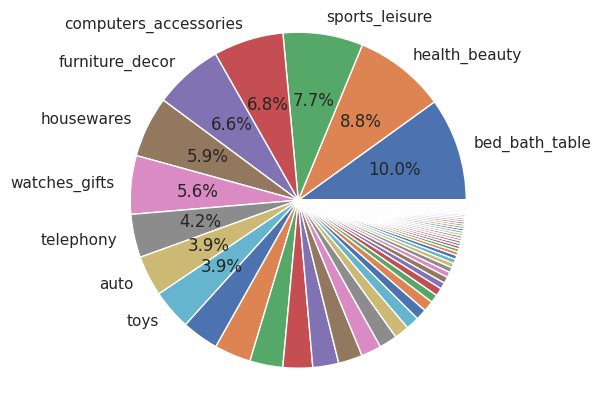

%  %_cumul
categ                                  
bed_bath_table            9.95     9.95
health_beauty             8.81    18.76
sports_leisure            7.69    26.45
computers_accessories     6.75    33.20
furniture_decor           6.64    39.84
housewares                5.87    45.71
watches_gifts             5.63    51.34
telephony                 4.17    55.51
auto                      3.90    59.41
toys                      3.87    63.28
cool_stuff                3.55    66.83
garden_tools              3.52    70.35
perfumery                 3.17    73.52
baby                      2.85    76.37
electronics               2.49    78.86
stationery                2.32    81.18
fashion_bags_accessories  1.94    83.12
pet_shop                  1.73    84.85

In [102]:
limit_perc = 3.7
show_unique_values(data_study, "product_category_name")

### Colonnes Numériques

In [103]:
show_corr_col(data_study, data_num, threshold=0.4, top=10)

col1                 col2   corr
1          price  order_value_by_item  0.916
2  freight_value  order_value_by_item  0.457
0          price        freight_value  0.418

On remarque plusieurs corrélations : 
 - très forte corrélation (>0.8) : entre le prix d'un article et le montant de l'article par commandes. Ce qui est logique, puisque nous l'avons calculé ainsi.
 - corrélation modérée (>0.4) : entre les frais de port et le prix. C'est moins logique, mais c'est pour ça que la corrélation est modérée.

In [104]:
data.describe().T

count         mean          std         min  \
efficient_delivery_elapse   106837.0    11.107016    10.177091 -188.975081   
payment_sequential          106837.0     1.094761     0.723067    1.000000   
payment_installments        106837.0     2.896029     2.724191    1.000000   
payment_value               106837.0    28.249854    39.095649    0.001800   
review_score                106837.0     4.073589     1.355780    1.000000   
order_item_id               106837.0     1.149723     0.557548    1.000000   
price                       106837.0    22.349453    33.858711    0.153000   
freight_value               106837.0     3.626058     2.864699    0.000000   
product_name_lenght         106837.0    48.235583    11.230665    5.000000   
product_description_lenght  106837.0   773.963206   653.043843    4.000000   
product_photos_qty          106837.0     2.217986     1.734293    1.000000   
product_weight_g            106837.0  2106.840870  3784.345586    2.000000   
product_length_cm           106837.0    30.183794    16.131030    7.000000   
product_height_cm           106837.0    16.425489    13.320130    2.000000   
product_width_cm            106837.0    23.106742    11.780845    6.000000   

                                   25%         50%          75%           max  
efficient_delivery_elapse     6.266296   11.522604    16.238368    146.016123  
payment_sequential            1.000000    1.000000     1.000000     29.000000  
payment_installments          1.000000    1.000000     4.000000     24.000000  
payment_value                10.382400   18.381600    31.669200   2459.534400  
review_score                  4.000000    5.000000     5.000000      5.000000  
order_item_id                 1.000000    1.000000     1.000000     21.000000  
price                         7.200000   14.040000    25.020000   1212.300000  
freight_value                 2.365200    2.941200     3.821400     73.742400  
product_name_lenght          42.000000   52.000000    57.000000     76.000000  
product_description_lenght  340.000000  594.000000   977.000000   3992.000000  
product_photos_qty            1.000000    1.000000     3.000000     20.000000  
product_weight_g            300.000000  700.000000  1800.000000  40425.000000  
product_length_cm            18.000000   25.000000    38.000000    105.000000  
product_height_cm             8.000000   13.000000    20.000000    105.000000  
product_width_cm             15.000000   20.000000    30.000000    118.000000

Concernant les outliers, je ne vois rien de particulier à première vue. Regardons plutôt à l'aide des boxplot.

----------------------------------------------------------------------
Colonne : efficient_delivery_elapse


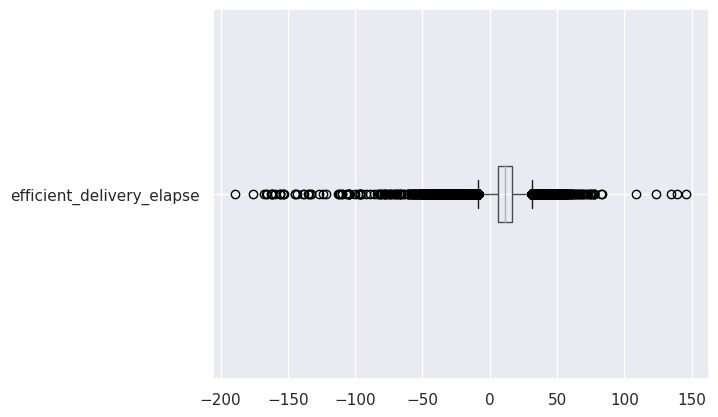

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : review_score


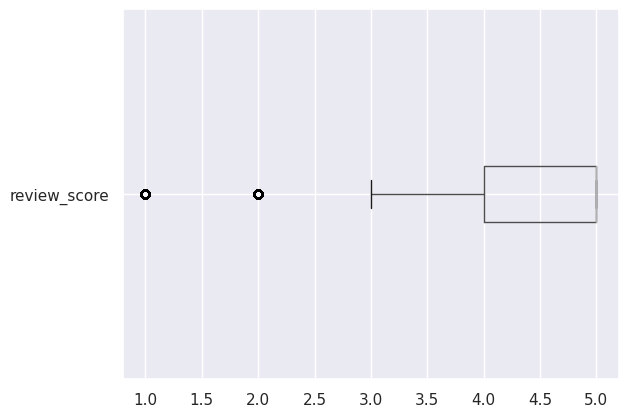

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : order_item_id


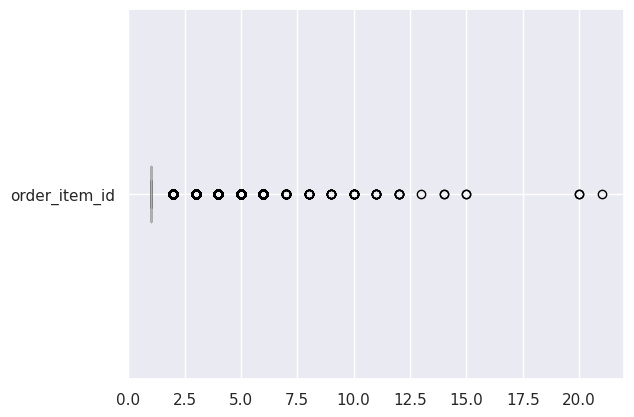

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : price


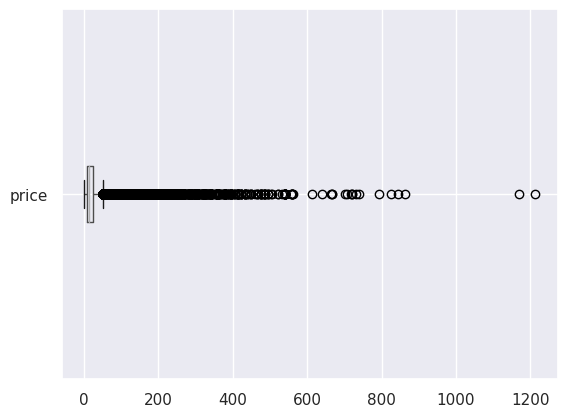

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : freight_value


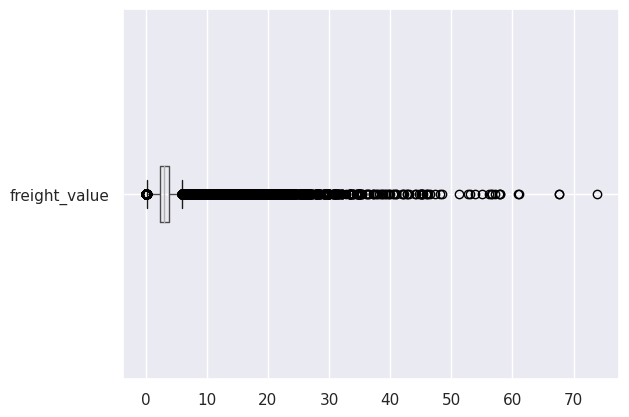

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_name_lenght


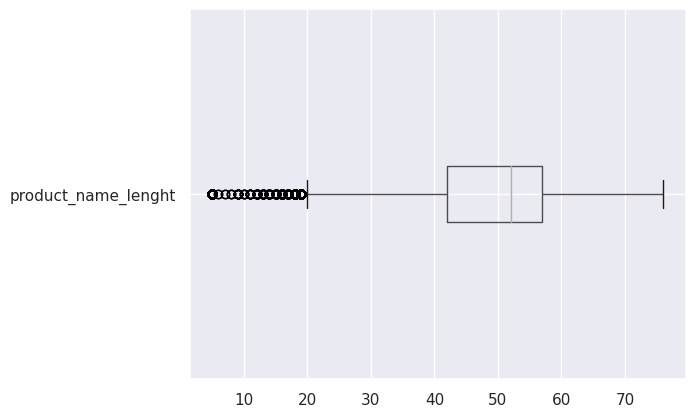

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_description_lenght


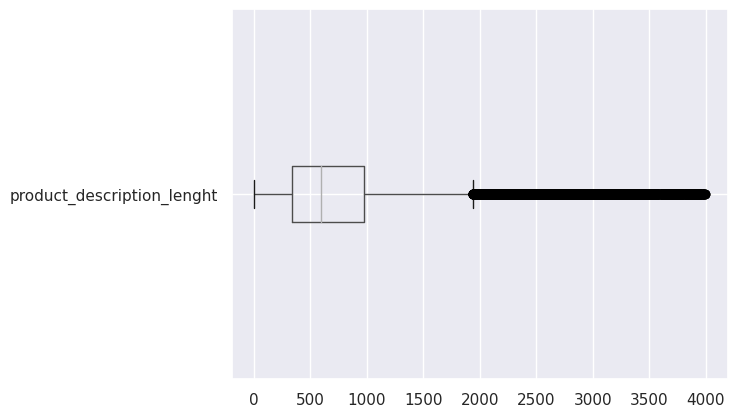

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_photos_qty


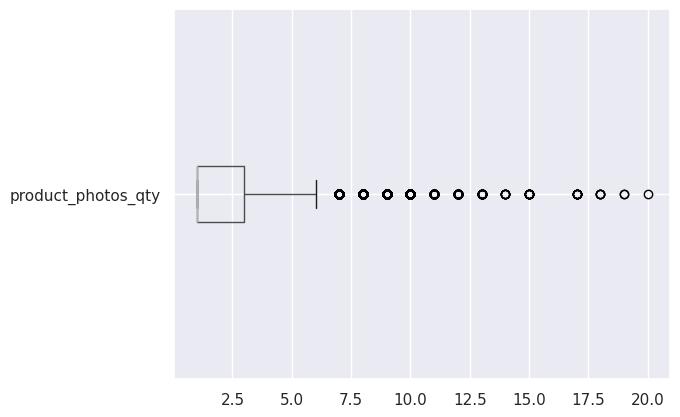

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : order_value_by_item


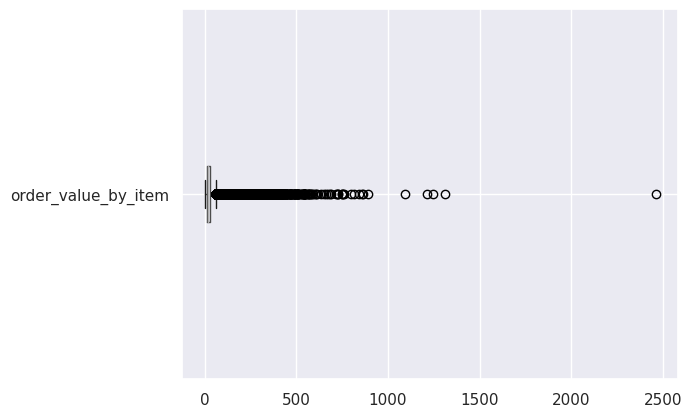

----------------------------------------------------------------------


In [105]:
boxplot_univarie(data_study, data_num.columns)

----------------------------------------------------------------------
Colonne : efficient_delivery_elapse
moyenne :  11.091286823964483
médiane :  11.49162037037037
mode :  0    0.0
Name: efficient_delivery_elapse, dtype: float64
min :  -188.97508101851852
max :  146.0161226851852
quartiles :  [6.2551041666666665, 16.240445601851853]
variance :  103.3374087116024
écart-type :  10.16550090805182
coefficient de variation :  0.9165303421860522
skewness :  -1.8700189903379691
kurtosis :  26.970102819164076


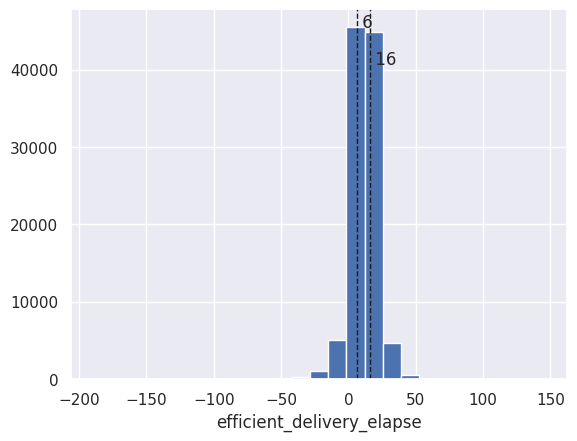

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : review_score
moyenne :  4.076367015553164
médiane :  5.0
mode :  0    5
Name: review_score, dtype: int64
min :  1
max :  5
quartiles :  [4.0, 5.0]
variance :  1.833364009679902
écart-type :  1.3540177287169848
coefficient de variation :  0.33216286059395567
skewness :  -1.344658578158898
kurtosis :  0.44462892747033544


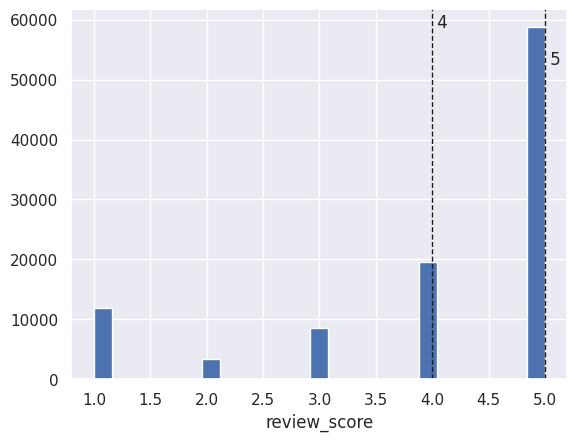

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : order_item_id
moyenne :  1.1502787831360657
médiane :  1.0
mode :  0    1
Name: order_item_id, dtype: int64
min :  1
max :  21
quartiles :  [1.0, 1.0]
variance :  0.31493951926714886
écart-type :  0.5611947249103014
coefficient de variation :  0.4878771417310564
skewness :  7.295881974174976
kurtosis :  103.61130370647132


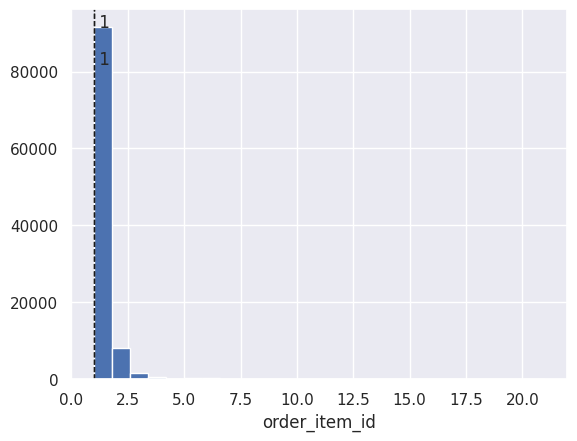

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : price
moyenne :  22.33374696077472
médiane :  14.04
mode :  0    10.782
Name: price, dtype: float64
min :  0.153
max :  1212.3
quartiles :  [7.199999999999999, 25.02]
variance :  1136.6622331894719
écart-type :  33.7144217389157
coefficient de variation :  1.5095730151384417
skewness :  7.563038610525204
kurtosis :  105.92996399831641


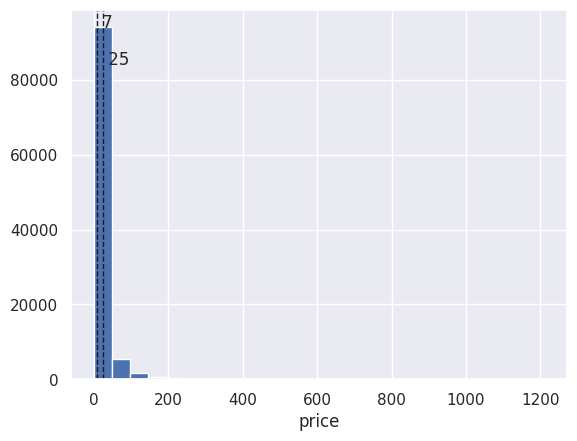

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : freight_value
moyenne :  3.6175424552479707
médiane :  2.9375999999999998
mode :  0    2.718
Name: freight_value, dtype: float64
min :  0.0
max :  73.7424
quartiles :  [2.3652, 3.8142]
variance :  8.147509164247245
écart-type :  2.8543842005320945
coefficient de variation :  0.7890395858081052
skewness :  5.548626296295178
kurtosis :  57.733596550942764


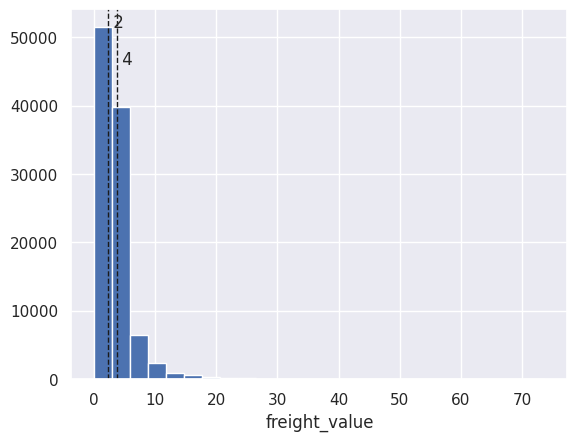

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_name_lenght
moyenne :  48.25299814144576
médiane :  52.0
mode :  0    59.0
Name: product_name_lenght, dtype: float64
min :  5.0
max :  76.0
quartiles :  [42.0, 57.0]
variance :  125.51507831428783
écart-type :  11.2033512090931
coefficient de variation :  0.23217938036207225
skewness :  -1.3305423015764968
kurtosis :  2.0186975739361985


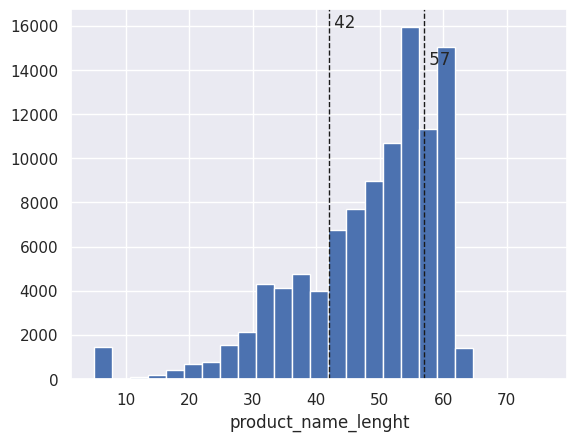

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_description_lenght
moyenne :  775.0866771006554
médiane :  595.0
mode :  0    4.0
Name: product_description_lenght, dtype: float64
min :  4.0
max :  3992.0
quartiles :  [341.0, 979.0]
variance :  425188.0324459964
écart-type :  652.0644388754814
coefficient de variation :  0.8412793796361463
skewness :  1.9878761869442145
kurtosis :  4.8977904775592


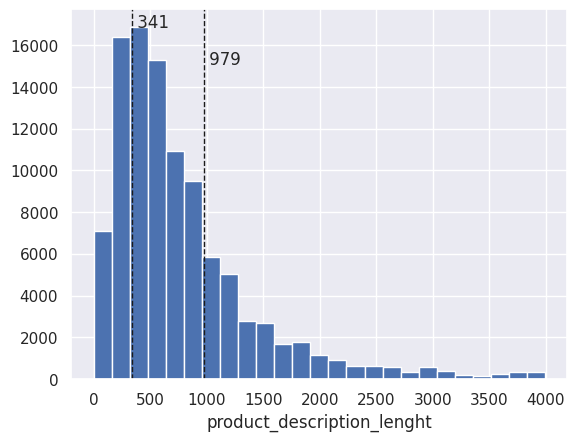

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_photos_qty
moyenne :  2.2198767485082658
médiane :  1.0
mode :  0    1.0
Name: product_photos_qty, dtype: float64
min :  1.0
max :  20.0
quartiles :  [1.0, 3.0]
variance :  3.014042946757617
écart-type :  1.736099924185707
coefficient de variation :  0.7820704124012057
skewness :  1.8986899412849012
kurtosis :  4.761527787074297


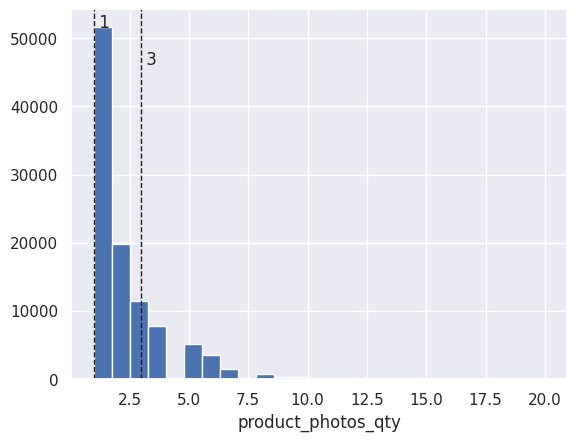

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : order_value_by_item
moyenne :  28.672585689132344
médiane :  18.7884
mode :  0    13.9626
Name: order_value_by_item, dtype: float64
min :  1.3104
max :  2459.5344
quartiles :  [11.09205, 31.6386]
variance :  1542.4193312917293
écart-type :  39.27364677861898
coefficient de variation :  1.3697281160626094
skewness :  9.080136998693122
kurtosis :  234.4605085767004


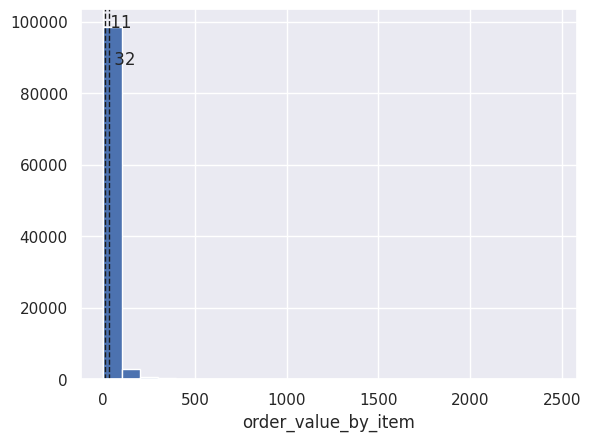

----------------------------------------------------------------------


In [106]:
plot_univarie(data_study, data_num.columns)

Il n'y a rien de particuliers à remarquer non plus en observant les répartition via les histogrammes. En revanche, nous pouvons afficher les pieplot des notes de review et de la quantité de photos, étant donné que les valeurs sont discrètes.

%  %_cumul
categ                
5      57.53    57.53
4      19.18    76.71
1      11.65    88.36
3       8.34    96.70
2       3.30   100.00

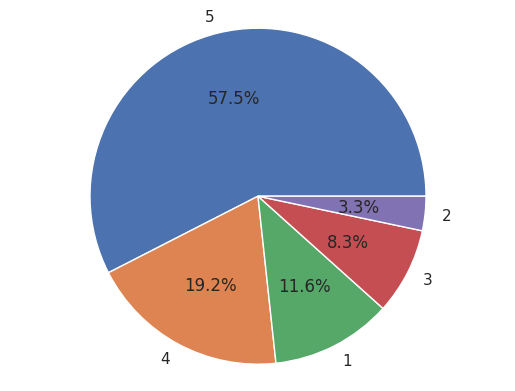

%  %_cumul
categ                
5      57.53    57.53
4      19.18    76.71

In [107]:
limit_perc = 3
show_unique_values(data_study, 'review_score')

In [108]:
maj_score_rev = data_study.loc[(data_study["review_score"]==5) | (data_study["review_score"]==4),:]
print("On peut voir que les notes 4 et 5 représentent", round(len(maj_score_rev)/len(data_study)*100, 1), "% des reviews.")

On peut voir que les notes 4 et 5 représentent 76.7 % des reviews.


%  %_cumul
categ                
1.0    50.54    50.54
2.0    19.38    69.92
3.0    11.22    81.14
4.0     7.59    88.73
5.0     4.98    93.71

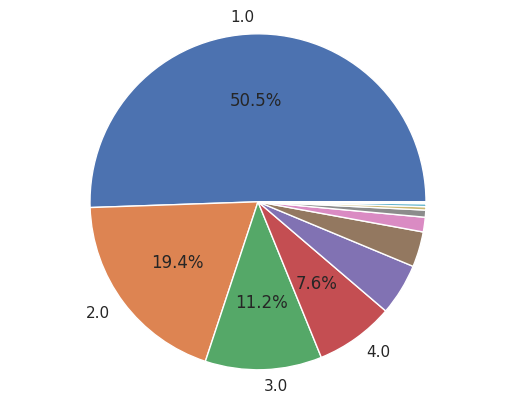

%  %_cumul
categ                
1.0    50.54    50.54
2.0    19.38    69.92
3.0    11.22    81.14

In [109]:
limit_perc = 5
show_unique_values(data_study, 'product_photos_qty')

In [110]:
maj_qty_photo = data_study.loc[
    (data_study["product_photos_qty"]==1) |
    (data_study["product_photos_qty"]==2) |
    (data_study["product_photos_qty"]==3),:
]
print("On peut voir que les produits ayant 1 à 3 photos représentent", round(len(maj_qty_photo)/len(data_study)*100, 1), "% des fiches produit.")

On peut voir que les produits ayant 1 à 3 photos représentent 81.2 % des fiches produit.


### Colonnes Date

Colonne order_purchase_timestamp


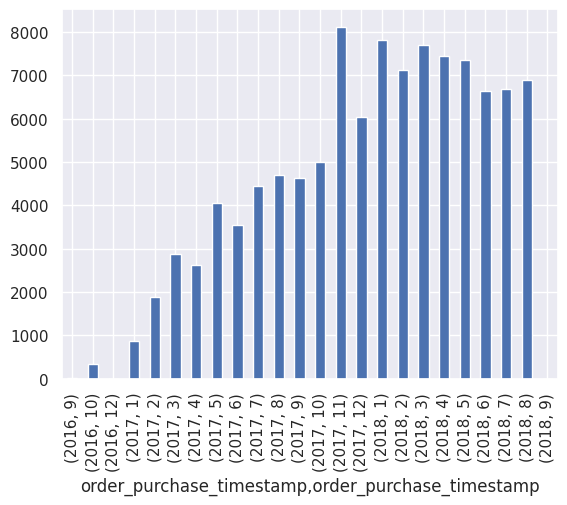

Colonne order_delivered_customer_date


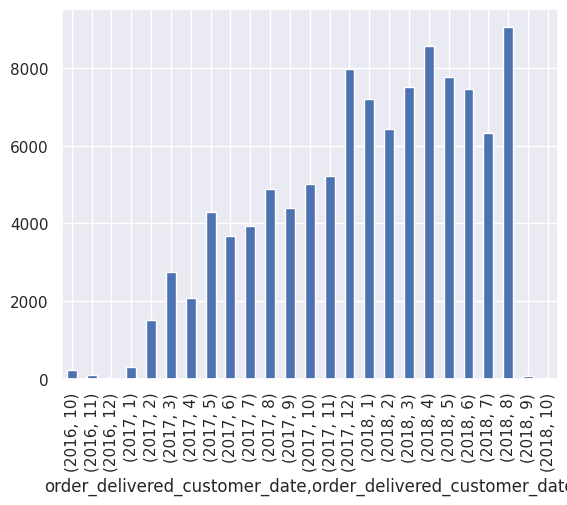

Colonne order_estimated_delivery_date


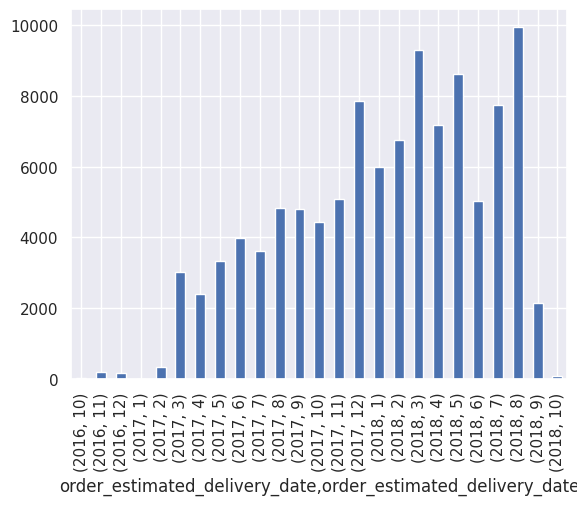

In [111]:
for col in data_date.columns:
    print("Colonne", col)
    data[col].groupby([data[col].dt.year, data[col].dt.month]).count().plot(kind="bar")
    plt.show()

La colonne `order_purchase_timestamp` sera utilisée dans le calcul des variables RFM. Nous avons des dates allant de 09/2016 à 04/2020. Il est surtout intéressant de voir que nous avons les données d'une entreprise en pleine expansion puisque le nombre d'éléments (clients, commandes, etc.) augmentent avec le temps.

In [112]:
# récupérer la période à laquelle appartient la date de la commande au format YYYY-mm
data_study["period"] = data_study['order_purchase_timestamp'].dt.strftime('%Y-%m')
data_study = data_study.sort_values(by="period")

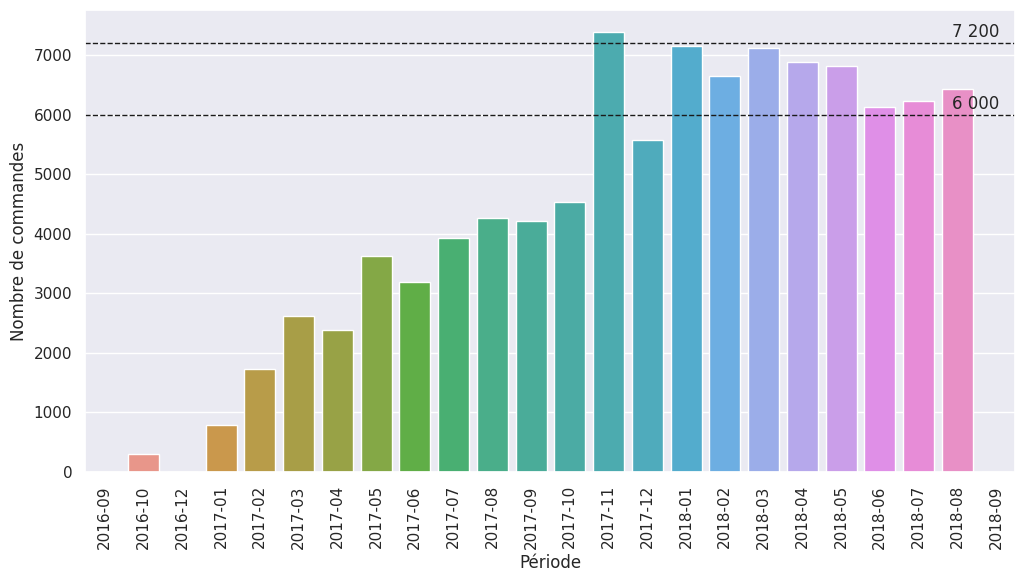

In [113]:
# on observe la répartition des commandes par période
df_monthly_active = data_study.groupby('period')['order_id'].nunique().reset_index()
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
sns.barplot(x='period', y='order_id', data=df_monthly_active)
plt.xlabel("Période")
plt.ylabel("Nombre de commandes")
ax.tick_params(axis='x', labelrotation=90)
min_xlim, max_xlim = plt.xlim()
plt.axhline(6000, color='k', linestyle='dashed', linewidth=1)
plt.text(max_xlim*0.93, 6100, '6 000')
plt.axhline(7200, color='k', linestyle='dashed', linewidth=1)
plt.text(max_xlim*0.93, 7300, '7 200')
plt.show()

In [114]:
nb_sell_nov_2017 = data_study.loc[data_study["period"] == '2017-11', :]
print("En novembre 2017, On observe un pic de", len(nb_sell_nov_2017), "commandes, soit", str(round(len(nb_sell_nov_2017)/len(data_study)*100, 2)), "% des commandes.")

En novembre 2017, On observe un pic de 7777 commandes, soit 7.61 % des commandes.


In [115]:
for annee in [2016, 2017, 2018]:
    order_year = data_study.loc[
        (data_study["period"] >= '{}-01'.format(annee)) &
        (data_study["period"] <= '{}-12'.format(annee)), :
    ]
    print("Pour l'année", annee, "il y a eu", len(order_year), "commandes, soit", str(round(len(order_year)/len(data_study)*100, 2)), "% des commandes.")

Pour l'année 2016 il y a eu 329 commandes, soit 0.32 % des commandes.
Pour l'année 2017 il y a eu 46283 commandes, soit 45.27 % des commandes.
Pour l'année 2018 il y a eu 55618 commandes, soit 54.4 % des commandes.


## Analyse multivariée

### Colonnes Numériques et Catégorielles

In [116]:
show_corr_anova_col(data_study, ["product_category_name"], data_num.columns, threshold=0.2)

On dénombre 9 combinaisons à calculer.
----------------------------------------------------------------------
Colonne catégorielle : product_category_name
Colonne numérique : product_name_lenght
Correlation de 0.263
Corrélations ANOVA calculées en : 2.0 s, soit 0.0 min, soit 0.0 h.


La recherche de corrélation entre les variables catégorielles et les variables nuémriques n'a rien donné de pertinent. En effet, avec un seuil supérieure à 0.2, nous avons une corrélation entre la catégorie du produit et la longueur de son intitulé.

### Colonnes Dates et Numériques

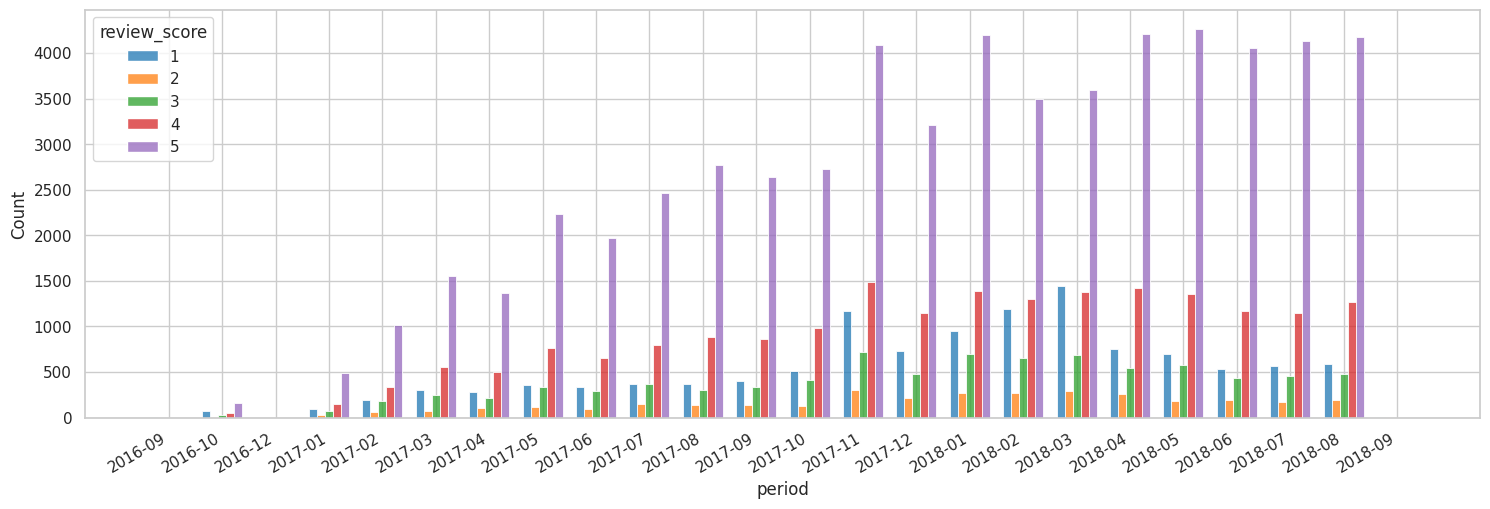

In [117]:
import matplotlib.dates as mdates
plt.figure(figsize=(18,6))
sns.histplot(data_study, x='period', hue='review_score',
             multiple='dodge', shrink=.75, bins=20, palette='tab10')
plt.gcf().autofmt_xdate()

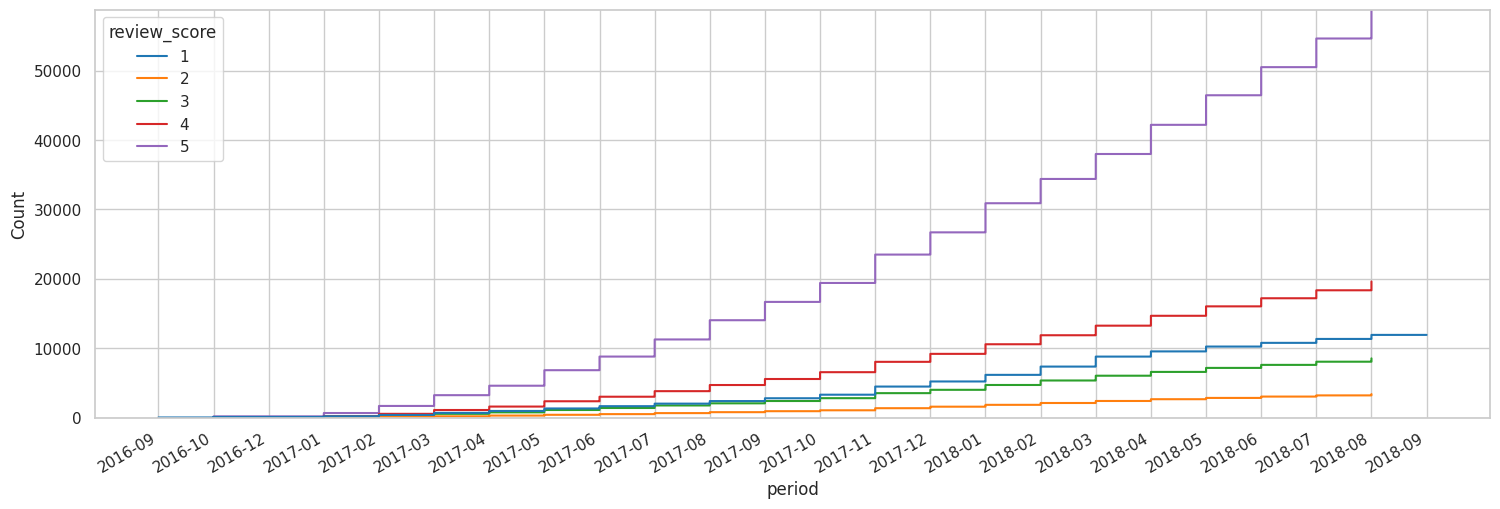

In [118]:
plt.figure(figsize=(18,6))
sns.ecdfplot(data_study, x='period', hue='review_score', palette='tab10', stat='count')
plt.gcf().autofmt_xdate()

On peut voir une évolution des notes avec notamment les notes 1 qui sont passées de la 4ème à la 3ème place concernant leur nombre.

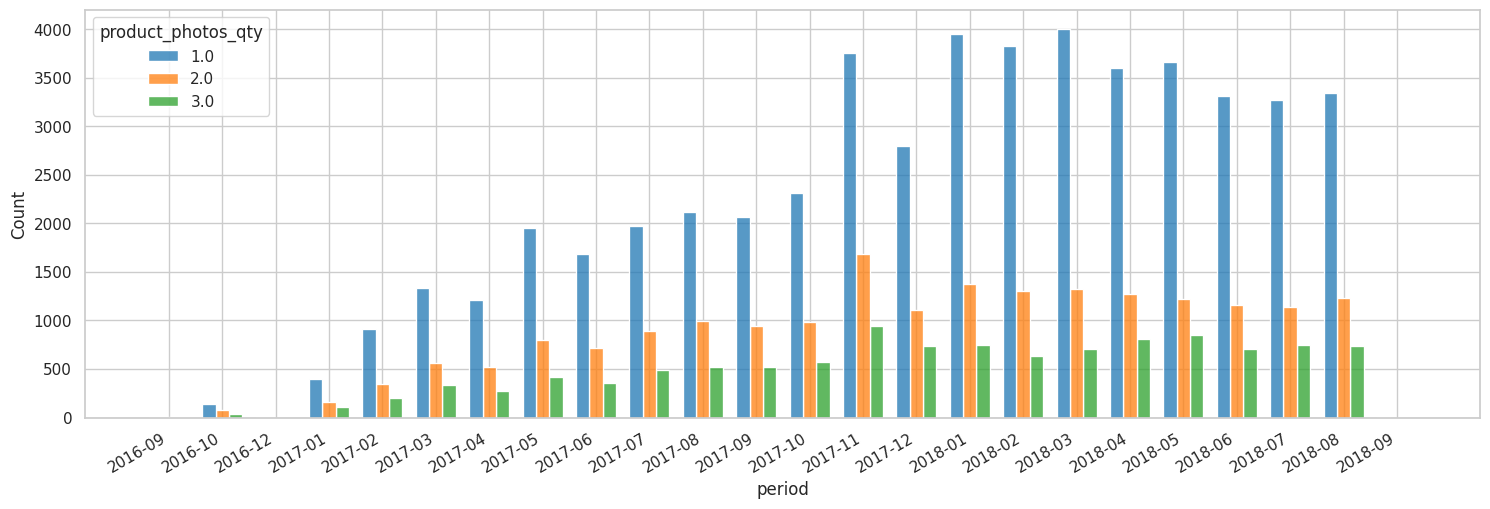

In [119]:
# on prend 80% des données pertinentes, càd un nb de photo de 1 à 3
maj_qty_photo = data_study.loc[data_study["product_photos_qty"].isin([1, 2, 3]),:]
plt.figure(figsize=(18,6))
sns.histplot(maj_qty_photo, x='period', hue='product_photos_qty',
             multiple='dodge', shrink=.75, bins=20, palette='tab10')
plt.gcf().autofmt_xdate()

### Colonnes Dates et Catégorielles

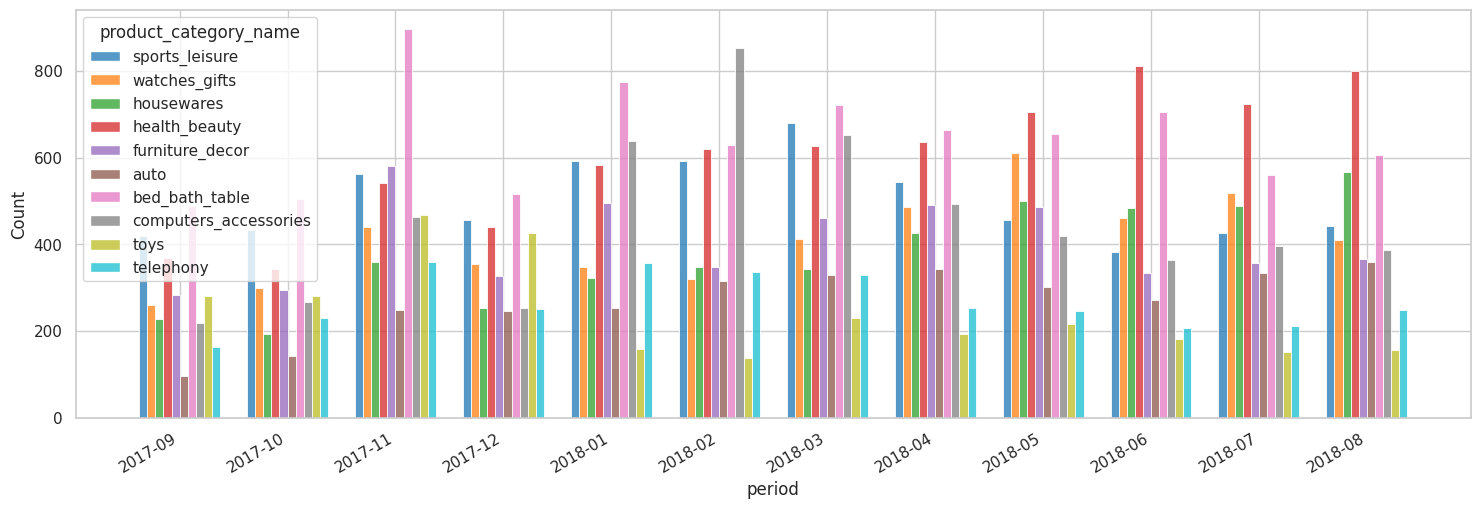

In [120]:
# on prend les 10 catégories les plus vendues, càd 60% des catégories
list_categories_10 = [
    "bed_bath_table", "health_beauty", "sports_leisure", "computers_accessories",
    "furniture_decor", "housewares", "watches_gifts", "telephony", "auto", "toys"]
    # "cool_stuff", "garden_tools", "perfumery", "baby", "electronics", "stationery"]
# pour une meilleure lisibilité, on va prendre la dernière année significative
# maj_categories = data_study.loc[data_study["product_category_name"].isin(list_categories_10), :]
maj_categories = data_study.loc[
    (data_study["product_category_name"].isin(list_categories_10)) &
    (data_study["period"] >= '2017-09'), :]

plt.figure(figsize=(18,6))
sns.histplot(maj_categories, x='period', hue='product_category_name',
             multiple='dodge', shrink=.75, bins=20, palette='tab10')
plt.gcf().autofmt_xdate()

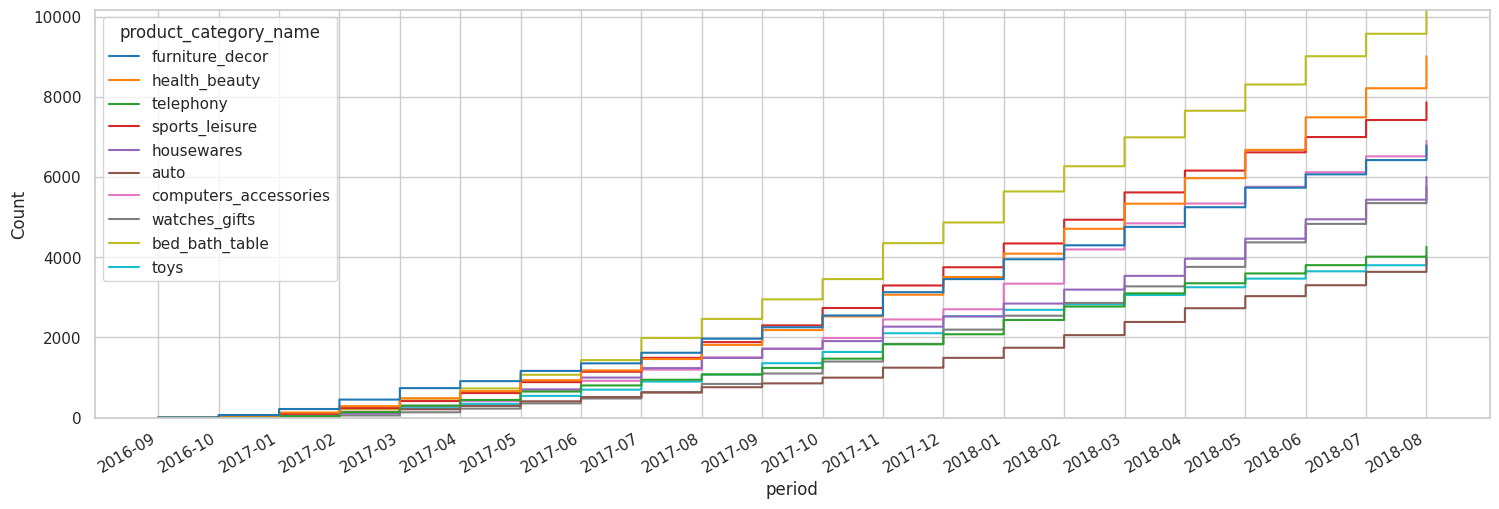

In [121]:
# on prend les 10 catégories les plus vendues, càd 60% des catégories
maj_categories = data_study.loc[data_study["product_category_name"].isin(list_categories_10), :]
plt.figure(figsize=(18,6))
sns.ecdfplot(maj_categories, x='period', hue='product_category_name', palette='tab10', stat='count')
plt.gcf().autofmt_xdate()

### Taux d'accroissement ventes

In [122]:
amount_by_period = data_study.groupby(['period']).agg({'order_value_by_item': 'sum'})
perc_amount_by_period = amount_by_period.pct_change()
perc_amount_by_period["order_value_by_item"] = perc_amount_by_period["order_value_by_item"]*100
perc_amount_by_period.reset_index(inplace=True)

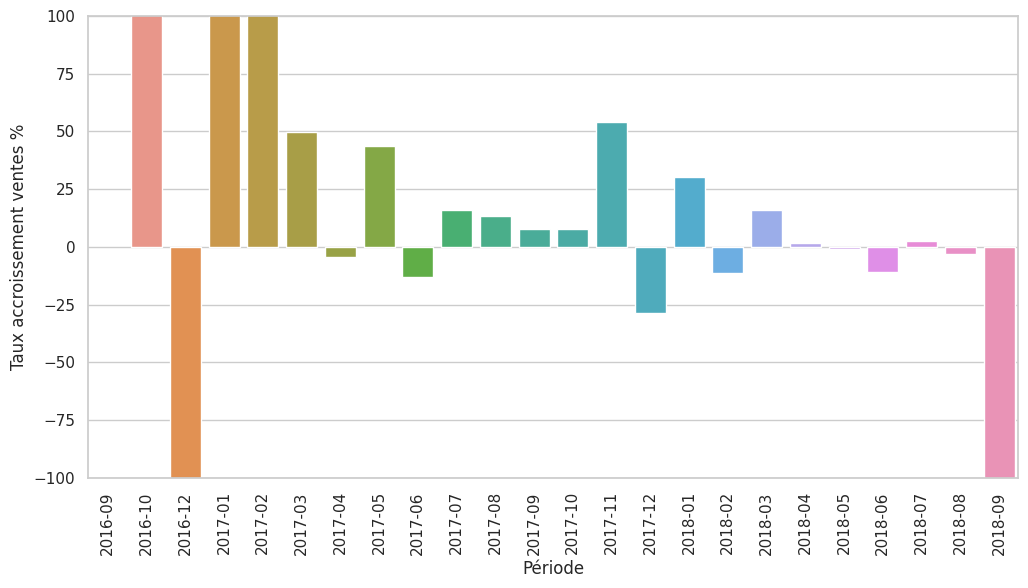

In [123]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
sns.barplot(x='period', y='order_value_by_item', data=perc_amount_by_period)
ax.tick_params(axis='x', labelrotation=90)
plt.ylim(-100, 100)
plt.ylabel("Taux accroissement ventes %")
plt.xlabel("Période")
plt.show()

### Taux d'accroissement clientèle

In [124]:
customer_by_period = data_study.groupby(['period']).agg({'customer_unique_id': 'count'})
perc_customer_by_period = customer_by_period.pct_change()
perc_customer_by_period["customer_unique_id"] = perc_customer_by_period["customer_unique_id"]*100
perc_customer_by_period.reset_index(inplace=True)

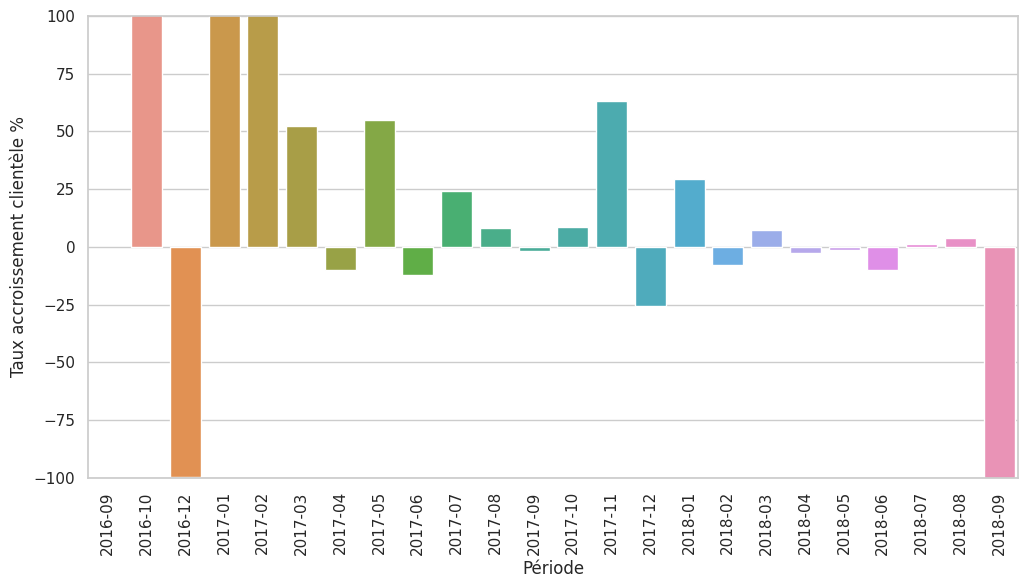

In [125]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
sns.barplot(x='period', y='customer_unique_id', data=perc_customer_by_period)
ax.tick_params(axis='x', labelrotation=90)
plt.ylim(-100, 100)
plt.ylabel("Taux accroissement clientèle %")
plt.xlabel("Période")
plt.show()

### Par période et par catégorie

In [126]:
data_by_period_by_categ = data_study.groupby(['period', 'product_category_name']).agg({'order_value_by_item': 'sum'})
data_by_period_by_categ.reset_index(inplace=True)

In [127]:
data_by_period_by_categ.head()

period product_category_name  order_value_by_item
0  2016-09       furniture_decor              36.1440
1  2016-09         health_beauty              25.8228
2  2016-09             telephony              13.5108
3  2016-10      air_conditioning             342.8838
4  2016-10                 audio              32.9454

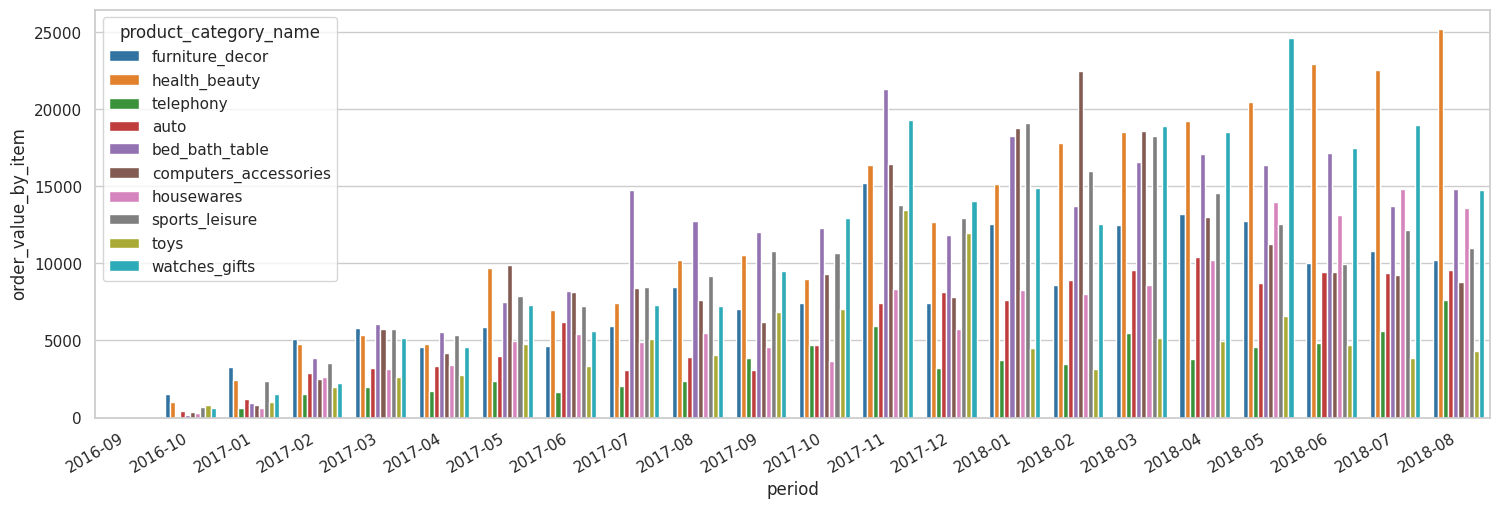

In [128]:
# on prend les 10 catégories les plus vendues, càd 60% des catégories
data_to_plot = data_by_period_by_categ.loc[data_by_period_by_categ["product_category_name"].isin(list_categories_10), :]
plt.figure(figsize=(18,6))
sns.barplot(data_to_plot, x='period', y='order_value_by_item', hue='product_category_name', palette='tab10')
plt.gcf().autofmt_xdate()

## Sélection meilleures clients

In [129]:
data_process.describe()

rfm_recency  rfm_frequency  rfm_monetary  panier_moyen  \
count  94721.000000   94721.000000  94721.000000  94721.000000   
mean     243.442827       1.079275     30.945603     28.594162   
std      153.170660       0.366482     43.912554     39.214542   
min        1.000000       1.000000      1.726200      1.726200   
25%      119.000000       1.000000     11.379600     11.161800   
50%      224.000000       1.000000     19.589400     18.856800   
75%      353.000000       1.000000     33.703200     31.397400   
max      729.000000      16.000000   2459.534400   2459.534400   

       avance_sur_livraison_moyen  review_score_mean   fiche_score  
count                94721.000000       94721.000000  94721.000000  
mean                    10.950476           4.102253      0.608580  
std                     10.093980           1.326603      0.156363  
min                   -188.975081           1.000000      0.000000  
25%                      6.228275           4.000000      0.521127  
50%                     11.380509           5.000000      0.647887  
75%                     16.172315           5.000000      0.732394  
max                    146.016123           5.000000      1.000000

### Sorted by monetary

In [130]:
data_sort_by_monetary = data_process.sort_values(by="rfm_monetary", ascending=False)
data_sort_by_monetary["%_monetary"] = (data_sort_by_monetary['rfm_monetary'] / data_sort_by_monetary['rfm_monetary'].sum()) * 100
data_sort_by_monetary["%_monetary_cumul"] = data_sort_by_monetary["%_monetary"].cumsum()
data_sort_by_monetary.head()

rfm_recency  rfm_frequency  rfm_monetary  \
customer_unique_id                                                           
0a0a92112bd4c708ca5fde585afaa872          339              1     2459.5344   
da122df9eeddfedc1dc1f5349a1a690c          520              2     1362.8934   
763c8b1c9c68a0229c42c9fc6f662b93           50              1     1309.4784   
dc4802a71eae9be1dd28f5d788ceb526          568              1     1247.2758   
d97b3cfb22b0d6b25ac9ed4e9c2d481b          321             13     1237.2120   

                                  panier_moyen  avance_sur_livraison_moyen  \
customer_unique_id                                                           
0a0a92112bd4c708ca5fde585afaa872   2459.534400                    5.234387   
da122df9eeddfedc1dc1f5349a1a690c    681.446700                   17.964884   
763c8b1c9c68a0229c42c9fc6f662b93   1309.478400                    6.081181   
dc4802a71eae9be1dd28f5d788ceb526   1247.275800                    5.400486   
d97b3cfb22b0d6b25ac9ed4e9c2d481b     95.170154                   12.156932   

                                  review_score_mean  fiche_score  %_monetary  \
customer_unique_id                                                             
0a0a92112bd4c708ca5fde585afaa872                1.0     0.478873    0.083909   
da122df9eeddfedc1dc1f5349a1a690c                5.0     0.507042    0.046496   
763c8b1c9c68a0229c42c9fc6f662b93                1.0     0.408451    0.044674   
dc4802a71eae9be1dd28f5d788ceb526                5.0     0.366197    0.042552   
d97b3cfb22b0d6b25ac9ed4e9c2d481b                1.0     0.384615    0.042208   

                                  %_monetary_cumul  
customer_unique_id                                  
0a0a92112bd4c708ca5fde585afaa872          0.083909  
da122df9eeddfedc1dc1f5349a1a690c          0.130405  
763c8b1c9c68a0229c42c9fc6f662b93          0.175079  
dc4802a71eae9be1dd28f5d788ceb526          0.217631  
d97b3cfb22b0d6b25ac9ed4e9c2d481b          0.259839

In [131]:
perc_60_customers = data_sort_by_monetary.loc[data_sort_by_monetary["%_monetary_cumul"] <= 60, :]
best_customers = data_study.loc[data_study["customer_unique_id"].isin(perc_60_customers.index), :]
top_categ_best = show_unique_values(best_customers, "product_category_name", display_pie=False, silent=True)

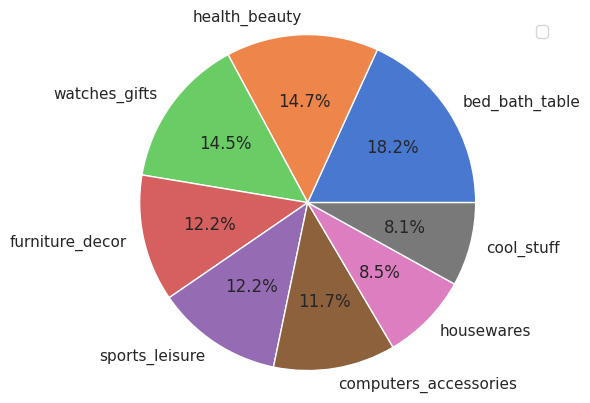

In [132]:
top_categ_best[:8].plot(kind='pie', y="%", label='', autopct='%.1f%%')
plt.legend('')
plt.axis('equal')
plt.show()

In [133]:
perc_80_customers = data_sort_by_monetary.loc[data_sort_by_monetary["%_monetary_cumul"] >= 60, :]
worst_customers = data_study.loc[data_study["customer_unique_id"].isin(perc_80_customers.index), :]
top_categ_worst = show_unique_values(worst_customers, "product_category_name", display_pie=False, silent=True)

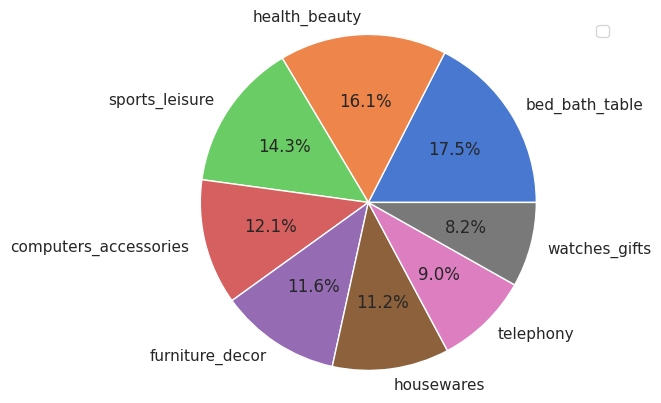

In [134]:
top_categ_worst[:8].plot(kind='pie', y="%", label='', autopct='%.1f%%')
plt.legend('')
plt.axis('equal')
plt.show()

### Sorted by panier moyen

In [135]:
data_sort_by_panier = data_process.sort_values(by="panier_moyen", ascending=False)
data_sort_by_panier["%_panier"] = (data_sort_by_panier['panier_moyen'] / data_sort_by_panier['panier_moyen'].sum()) * 100
data_sort_by_panier["%_panier_cumul"] = data_sort_by_panier["%_panier"].cumsum()
data_sort_by_panier.head()

rfm_recency  rfm_frequency  rfm_monetary  \
customer_unique_id                                                           
0a0a92112bd4c708ca5fde585afaa872          339              1     2459.5344   
763c8b1c9c68a0229c42c9fc6f662b93           50              1     1309.4784   
dc4802a71eae9be1dd28f5d788ceb526          568              1     1247.2758   
ff4159b92c40ebe40454e3e6a7c35ed6          467              1     1210.7988   
4007669dec559734d6f53e029e360987          283              1     1094.6772   

                                  panier_moyen  avance_sur_livraison_moyen  \
customer_unique_id                                                           
0a0a92112bd4c708ca5fde585afaa872     2459.5344                    5.234387   
763c8b1c9c68a0229c42c9fc6f662b93     1309.4784                    6.081181   
dc4802a71eae9be1dd28f5d788ceb526     1247.2758                    5.400486   
ff4159b92c40ebe40454e3e6a7c35ed6     1210.7988                   22.284861   
4007669dec559734d6f53e029e360987     1094.6772                    8.488866   

                                  review_score_mean  fiche_score  %_panier  \
customer_unique_id                                                           
0a0a92112bd4c708ca5fde585afaa872                1.0     0.478873  0.090809   
763c8b1c9c68a0229c42c9fc6f662b93                1.0     0.408451  0.048348   
dc4802a71eae9be1dd28f5d788ceb526                5.0     0.366197  0.046051   
ff4159b92c40ebe40454e3e6a7c35ed6                5.0     0.323944  0.044704   
4007669dec559734d6f53e029e360987                1.0     0.676056  0.040417   

                                  %_panier_cumul  
customer_unique_id                                
0a0a92112bd4c708ca5fde585afaa872        0.090809  
763c8b1c9c68a0229c42c9fc6f662b93        0.139157  
dc4802a71eae9be1dd28f5d788ceb526        0.185208  
ff4159b92c40ebe40454e3e6a7c35ed6        0.229912  
4007669dec559734d6f53e029e360987        0.270329

In [136]:
perc_60_customers = data_sort_by_panier.loc[data_sort_by_panier["%_panier_cumul"] <= 60, :]
best_customers = data_study.loc[data_study["customer_unique_id"].isin(perc_60_customers.index), :]
top_categ_best = show_unique_values(best_customers, "product_category_name", display_pie=False, silent=True)

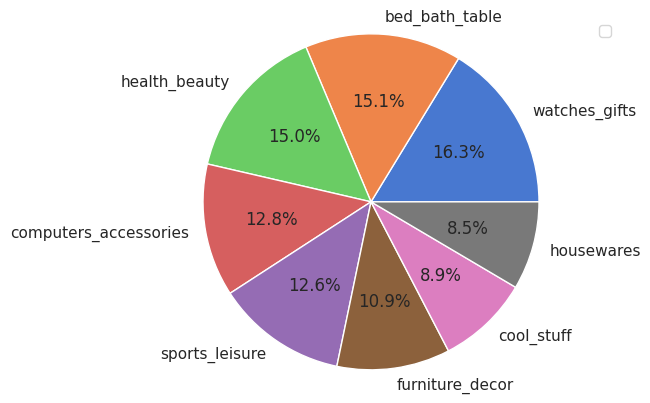

In [137]:
top_categ_best[:8].plot(kind='pie', y="%", label='', autopct='%.1f%%')
plt.legend('')
plt.axis('equal')
plt.show()

In [138]:
perc_80_customers = data_sort_by_panier.loc[data_sort_by_panier["%_panier_cumul"] >= 60, :]
worst_customers = data_study.loc[data_study["customer_unique_id"].isin(perc_80_customers.index), :]
top_categ_worst = show_unique_values(worst_customers, "product_category_name", display_pie=False, silent=True)

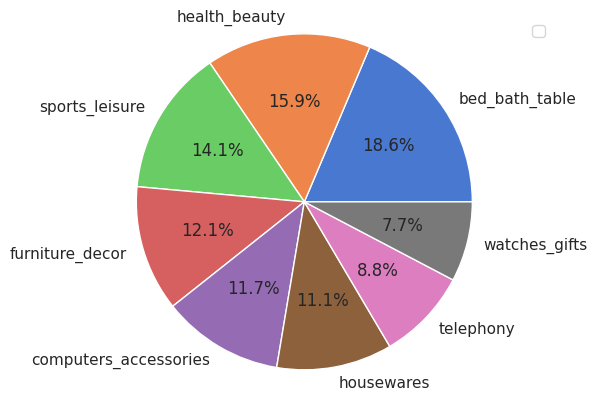

In [139]:
top_categ_worst[:8].plot(kind='pie', y="%", label='', autopct='%.1f%%')
plt.legend('')
plt.axis('equal')
plt.show()

## Sélection meilleures catégories de produit

In [140]:
agg_product = {
    'order_purchase_timestamp': lambda x: (last_purchase_date - x.max()).days,
    'order_id': 'count',
    'order_value_by_item': ['sum', 'mean'],
    'efficient_delivery_elapse': 'mean',
    'review_score': 'mean',
    'product_name_lenght': 'mean',
    'product_description_lenght': 'mean',
    'product_photos_qty': 'mean'
}

In [141]:
data_process_product = data_study.groupby(['product_id']).agg(agg_product)
data_process_product.columns = pd.Index([e[0] + "_" + e[1] for e in data_process_product.columns.tolist()])
data_process_product.rename(
    columns={'order_purchase_timestamp_<lambda>': 'rfm_recency',
             'order_id_count': 'rfm_frequency',
             'order_value_by_item_sum': 'rfm_monetary',
             'order_value_by_item_mean': 'panier_moyen',
             'efficient_delivery_elapse_mean': 'avance_sur_livraison_moyen'}, inplace=True)

In [142]:
data_process_product.describe()

rfm_recency  rfm_frequency  rfm_monetary  panier_moyen  \
count  32789.000000   32789.000000  32789.000000  32789.000000   
mean     212.969624       3.117814     89.395786     33.289360   
std      160.346093       9.465027    282.728817     51.025189   
min        1.000000       1.000000      1.726200      1.726200   
25%       74.000000       1.000000     15.476400     11.199600   
50%      182.000000       1.000000     31.881600     19.675888   
75%      321.000000       2.000000     73.661400     35.564400   
max      729.000000     461.000000  12230.076600   2459.534400   

       avance_sur_livraison_moyen  review_score_mean  \
count                32789.000000       32789.000000   
mean                    11.308799           4.054133   
std                      9.324386           1.207461   
min                   -167.708414           1.000000   
25%                      7.016296           3.666667   
50%                     11.328750           4.500000   
75%                     15.575309           5.000000   
max                    139.397396           5.000000   

       product_name_lenght_mean  product_description_lenght_mean  \
count              32789.000000                     32789.000000   
mean                  47.679771                       757.485498   
std                   11.707633                       638.005620   
min                    5.000000                         4.000000   
25%                   41.000000                       326.000000   
50%                   51.000000                       584.000000   
75%                   57.000000                       961.000000   
max                   76.000000                      3992.000000   

       product_photos_qty_mean  
count             32789.000000  
mean                  2.167556  
std                   1.728803  
min                   1.000000  
25%                   1.000000  
50%                   1.000000  
75%                   3.000000  
max                  20.000000

### Sorted by monetary

In [143]:
data_sort_by_monetary = data_process_product.sort_values(by="rfm_monetary", ascending=False)
data_sort_by_monetary["%_monetary"] = (data_sort_by_monetary['rfm_monetary'] / data_sort_by_monetary['rfm_monetary'].sum()) * 100
data_sort_by_monetary["%_monetary_cumul"] = data_sort_by_monetary["%_monetary"].cumsum()
data_sort_by_monetary.head()

rfm_recency  rfm_frequency  rfm_monetary  \
product_id                                                                   
bb50f2e236e5eea0100680137654686c            8            188    12230.0766   
d1c427060a0f73f6b889a5c7c61f2ac4           12            320    11060.8398   
6cdd53843498f92890544667809f1595           13            150    10637.3142   
99a4788cb24856965c36a24e339b6058           15            461     9691.5240   
d6160fb7873f184099d9bc95e30376af          331             35     9058.7124   

                                  panier_moyen  avance_sur_livraison_moyen  \
product_id                                                                   
bb50f2e236e5eea0100680137654686c     65.053599                    8.380015   
d1c427060a0f73f6b889a5c7c61f2ac4     34.565124                   12.079681   
6cdd53843498f92890544667809f1595     70.915428                   15.424744   
99a4788cb24856965c36a24e339b6058     21.022829                    9.325604   
d6160fb7873f184099d9bc95e30376af    258.820354                   11.105469   

                                  review_score_mean  product_name_lenght_mean  \
product_id                                                                      
bb50f2e236e5eea0100680137654686c           4.212766                      60.0   
d1c427060a0f73f6b889a5c7c61f2ac4           4.234375                      59.0   
6cdd53843498f92890544667809f1595           4.320000                      51.0   
99a4788cb24856965c36a24e339b6058           3.904555                      54.0   
d6160fb7873f184099d9bc95e30376af           4.571429                      55.0   

                                  product_description_lenght_mean  \
product_id                                                          
bb50f2e236e5eea0100680137654686c                           2644.0   
d1c427060a0f73f6b889a5c7c61f2ac4                           1893.0   
6cdd53843498f92890544667809f1595                            625.0   
99a4788cb24856965c36a24e339b6058                            245.0   
d6160fb7873f184099d9bc95e30376af                           3632.0   

                                  product_photos_qty_mean  %_monetary  \
product_id                                                              
bb50f2e236e5eea0100680137654686c                      6.0    0.417238   
d1c427060a0f73f6b889a5c7c61f2ac4                      1.0    0.377349   
6cdd53843498f92890544667809f1595                      1.0    0.362900   
99a4788cb24856965c36a24e339b6058                      1.0    0.330634   
d6160fb7873f184099d9bc95e30376af                      4.0    0.309045   

                                  %_monetary_cumul  
product_id                                          
bb50f2e236e5eea0100680137654686c          0.417238  
d1c427060a0f73f6b889a5c7c61f2ac4          0.794587  
6cdd53843498f92890544667809f1595          1.157487  
99a4788cb24856965c36a24e339b6058          1.488120  
d6160fb7873f184099d9bc95e30376af          1.797165

In [144]:
perc_60_customers = data_sort_by_monetary.loc[data_sort_by_monetary["%_monetary_cumul"] <= 60, :]
best_customers = data_study.loc[data_study["product_id"].isin(perc_60_customers.index), :]
top_categ_best = show_unique_values(best_customers, "product_category_name", display_pie=False, silent=True)

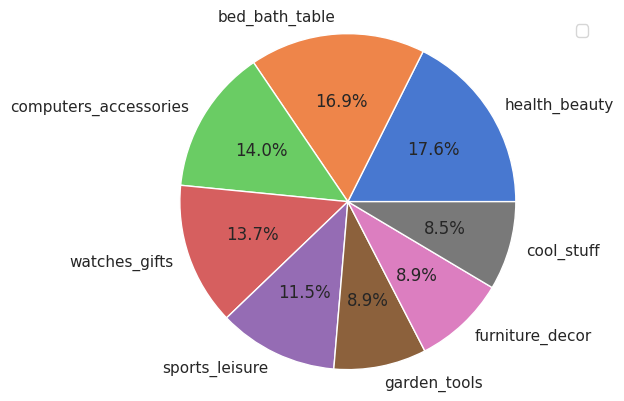

In [145]:
top_categ_best[:8].plot(kind='pie', y="%", label='', autopct='%.1f%%')
plt.legend('')
plt.axis('equal')
plt.show()

In [146]:
perc_80_customers = data_sort_by_monetary.loc[data_sort_by_monetary["%_monetary_cumul"] >= 60, :]
worst_customers = data_study.loc[data_study["product_id"].isin(perc_80_customers.index), :]
top_categ_worst = show_unique_values(worst_customers, "product_category_name", display_pie=False, silent=True)

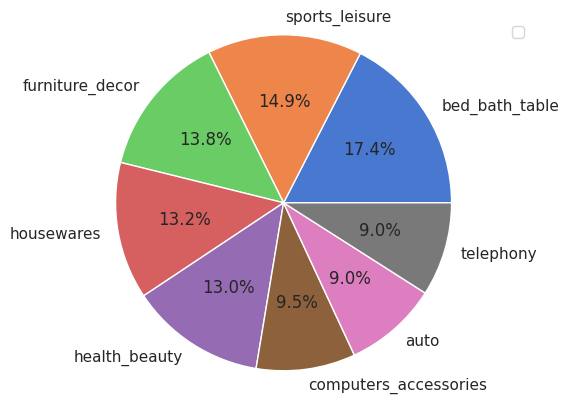

In [147]:
top_categ_worst[:8].plot(kind='pie', y="%", label='', autopct='%.1f%%')
plt.legend('')
plt.axis('equal')
plt.show()

### Sorted by panier moyen

In [148]:
data_sort_by_panier = data_process_product.sort_values(by="panier_moyen", ascending=False)
data_sort_by_panier["%_panier"] = (data_sort_by_panier['panier_moyen'] / data_sort_by_panier['panier_moyen'].sum()) * 100
data_sort_by_panier["%_panier_cumul"] = data_sort_by_panier["%_panier"].cumsum()
data_sort_by_panier.head()

rfm_recency  rfm_frequency  rfm_monetary  \
product_id                                                                   
5769ef0a239114ac3a854af00df129e4          339              1     2459.5344   
489ae2aa008f021502940f251d4cce7f          568              1     1247.2758   
1bdf5e6731585cf01aa8169c7028d6ad          467              1     1210.7988   
c183fd5d2abf05873fa6e1014ed9e06c          283              1     1094.6772   
19936fa4f614ee0590d3b77ac83fd648           50              2     1913.9616   

                                  panier_moyen  avance_sur_livraison_moyen  \
product_id                                                                   
5769ef0a239114ac3a854af00df129e4     2459.5344                    5.234387   
489ae2aa008f021502940f251d4cce7f     1247.2758                    5.400486   
1bdf5e6731585cf01aa8169c7028d6ad     1210.7988                   22.284861   
c183fd5d2abf05873fa6e1014ed9e06c     1094.6772                    8.488866   
19936fa4f614ee0590d3b77ac83fd648      956.9808                    7.156898   

                                  review_score_mean  product_name_lenght_mean  \
product_id                                                                      
5769ef0a239114ac3a854af00df129e4                1.0                      39.0   
489ae2aa008f021502940f251d4cce7f                5.0                      31.0   
1bdf5e6731585cf01aa8169c7028d6ad                5.0                      28.0   
c183fd5d2abf05873fa6e1014ed9e06c                1.0                      53.0   
19936fa4f614ee0590d3b77ac83fd648                1.5                      34.0   

                                  product_description_lenght_mean  \
product_id                                                          
5769ef0a239114ac3a854af00df129e4                           2493.0   
489ae2aa008f021502940f251d4cce7f                            875.0   
1bdf5e6731585cf01aa8169c7028d6ad                           3954.0   
c183fd5d2abf05873fa6e1014ed9e06c                           1461.0   
19936fa4f614ee0590d3b77ac83fd648                           1016.0   

                                  product_photos_qty_mean  %_panier  \
product_id                                                            
5769ef0a239114ac3a854af00df129e4                      3.0  0.225330   
489ae2aa008f021502940f251d4cce7f                      2.0  0.114269   
1bdf5e6731585cf01aa8169c7028d6ad                      2.0  0.110927   
c183fd5d2abf05873fa6e1014ed9e06c                      1.0  0.100289   
19936fa4f614ee0590d3b77ac83fd648                      2.0  0.087674   

                                  %_panier_cumul  
product_id                                        
5769ef0a239114ac3a854af00df129e4        0.225330  
489ae2aa008f021502940f251d4cce7f        0.339599  
1bdf5e6731585cf01aa8169c7028d6ad        0.450527  
c183fd5d2abf05873fa6e1014ed9e06c        0.550815  
19936fa4f614ee0590d3b77ac83fd648        0.638489

In [149]:
perc_60_customers = data_sort_by_panier.loc[data_sort_by_panier["%_panier_cumul"] <= 60, :]
best_customers = data_study.loc[data_study["product_id"].isin(perc_60_customers.index), :]
top_categ_best = show_unique_values(best_customers, "product_category_name", display_pie=False, silent=True)

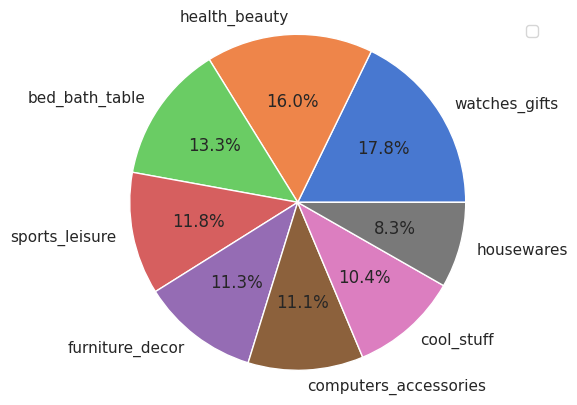

In [150]:
top_categ_best[:8].plot(kind='pie', y="%", label='', autopct='%.1f%%')
plt.legend('')
plt.axis('equal')
plt.show()

In [151]:
perc_80_customers = data_sort_by_panier.loc[data_sort_by_panier["%_panier_cumul"] >= 60, :]
worst_customers = data_study.loc[data_study["product_id"].isin(perc_80_customers.index), :]
top_categ_worst = show_unique_values(worst_customers, "product_category_name", display_pie=False, silent=True)

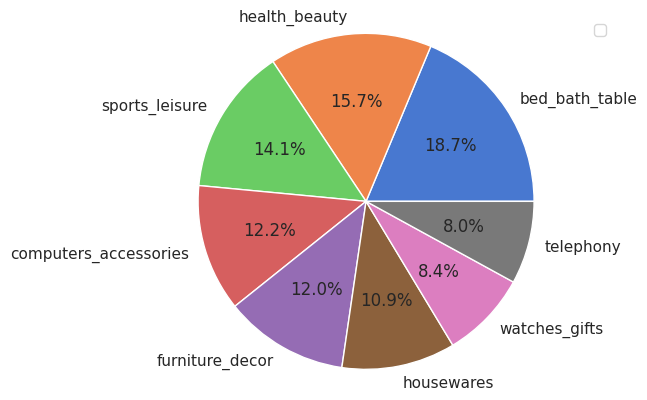

In [152]:
top_categ_worst[:8].plot(kind='pie', y="%", label='', autopct='%.1f%%')
plt.legend('')
plt.axis('equal')
plt.show()